# 1 Data Wrangling<a id='1_data_wrangling'></a>

In [1]:
# Import external libraries
import os
import sys
from datetime import datetime, date
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import local libraries
sys.path.append('..') # Add parent folder for local library imports

# Feature creation functions
from src.features.make_features import *
# Helper functions
from src.utils.helpers import *
# Visualization functions
from src.visuals.make_plots import *
# Import API key
from src.utils.params import lunar_api_key

# Load the "autoreload" extension so that code can change
%load_ext autoreload
#%reload_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## 1.1 Data Collection

The goal of this project is to build a "Crypto"currency Investment recommendation dashboard.  I will be focusing on short-term 7 day rolling window holding period.  I'm fascinated by the social aspect of crypto price influence and my research on this topic landed on [LunarCRUSH](https://lunarcrush.com/about).  LunarCRUSH delivers community insights to crypto investors, funds and exchanges.  Through resource applications and API's, get real-time insights that help make informed crypto investment decisions."  I will be using the assets API endpoint from LunarCRUSH and technical analysis metrics/indicators to make Buy/Hold/Sell recommendations.

In [3]:
# Create base lunarcrush api url
base_url = 'https://api.lunarcrush.com/v2?'

In [4]:
market_params = {'data': 'market',
                 'key': lunar_api_key
                }

market = requests.get(base_url, params=market_params).json()

all_coins = [i['s'] for i in market['data']]

print(len(all_coins))

2817


I will focus on the following 2 coins for this project:

1. Bitcoin (BTC)
2. Dogecoin (DOGE)

Bitcoin is the first decentralized cryptocurrency created in 2009.  Dogecoin is a memecoin that was originally created as a joke but has been in the social media based on support from influencer Elon Musk, Tesla CEO.

In [5]:
# Validate coin symbols exist in data
coins = ['BTC', 'DOGE']
[coin for coin in all_coins if coin in coins]

['DOGE', 'BTC']

In [6]:
# Create api params for assets endpoint
assets_params = {'data': 'assets',
                 'key': lunar_api_key,
                 'symbol': ",".join(coins),
                 'interval': 'day',
                 'change': '1d',
                 'data_points': 720}

# Get asset data
assets = requests.get(base_url, params=assets_params).json()

The current price and market data is stored in the data key and historical data is stored in the timeSeries key.

In [7]:
# Create DataFrame for each coin and store in dictionary
dfs = {}
for i in range(len(coins)):
    df = pd.DataFrame(assets['data'][i]['timeSeries'])
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('date', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df['name'] = assets['data'][i]['name']
    symbol = assets['data'][i]['symbol']
    df['symbol'] = symbol
    # Store df in dictionary
    dfs[symbol] = df

## 1.2 Data Definition

In [8]:
for coin in coins:
    print(coin,':')
    print(dfs[coin].info())
    print('------------------------------------------')

BTC :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2019-08-20 to 2021-08-08
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 720 non-null    int64  
 1   time                     720 non-null    int64  
 2   open                     720 non-null    float64
 3   close                    720 non-null    float64
 4   high                     720 non-null    float64
 5   low                      720 non-null    float64
 6   volume                   720 non-null    float64
 7   market_cap               698 non-null    float64
 8   url_shares               712 non-null    float64
 9   unique_url_shares        712 non-null    float64
 10  reddit_posts             710 non-null    float64
 11  reddit_posts_score       710 non-null    float64
 12  reddit_comments          710 non-null    float64
 13  reddit_comments_score    710 non-null    float64
 14  t

##### LunarCrush API field descriptions

| Column   |      Description      |
|:----------|:-------------|
| asset_id |  The LunarCRUSH id for an asset/coin |
| time |    A unix timestamp (in seconds)   |
| open | Open price for the time period |
| close | Close price for the time period |
| high | Highest price for the time period |
| low | Lowest price for the time period |
| volume | Volume for the time period in USD |
| market_cap | Total available supply multiplied by the current price in USD |
| url_shares | Number of urls shared and collected on social |
| unique_url_shares | Number of unique url shares posted and collected on social |
| reddit_posts | Number of reddit posts collected |
| reddit_posts_score | Sum of reddit karma on social posts |
| reddit_comments | Number of reddit comments collected |
| reddit_comments_score | Sum of reddit karma on collected comments |
| tweets | Number of tweets collected |
| tweets_spam | Number of tweets classified as spam |
| tweets_followers | Sum of follower count for every tweet collected |
| tweet_quotes | Sum of the number of times all collected tweets were quoted |
| tweet_retweets | Sum of the number of times all collected tweets were retweeted |
| tweet_replies | Sum of the number of times all collected tweet reply counts |
| tweet_favorites | Sum of the number of times all collected tweet likes |
| tweet_sentiment1 | Sum of tweets classified as sentiment 1 (Very Bearish) |
| tweet_sentiment2 | Sum of tweets classified as sentiment 2 (Bearish) |
| tweet_sentiment3 | Sum of tweets classified as sentiment 3 (Neutral) |
| tweet_sentiment4 | Sum of tweets classified as sentiment 4 (Bullish) |
| tweet_sentiment5 | Sum of tweets classified as sentiment 5 (Very Bullish) |
| tweet_sentiment_impact1 | Sum of social score (engagement) of all tweets classified as sentiment 1 (Very Bearish) |
| tweet_sentiment_impact2 | Sum of social score (engagement) of all tweets classified as sentiment 2 (Bearish) |
| tweet_sentiment_impact3 | Sum of social score (engagement) of all tweets classified as sentiment 3 (Neutral) |
| tweet_sentiment_impact4 | Sum of social score (engagement) of all tweets classified as sentiment 4 (Bullish) |
| tweet_sentiment_impact5 | Sum of social score (engagement) of all tweets classified as sentiment 5 (Very Bullish) |
| social_score | Sum of followers, retweets, likes, reddit karma etc of social posts collected |
| average_sentiment | Average sentiment of collected social posts |
| sentiment_absolute | Percent of bullish or very bullish tweets |
| sentiment_relative | Percent tweets that are bullish (excluding neutral in the count) |
| news | Number of news articles published |
| price_score | A proprietary score based mostly on the change in MACD over time |
| social_impact_score | A proprietary score based on the relative trend of social_score |
| correlation_rank | A score based on how the assets social metrics correlate with price and volume |
| galaxy_score | A proprietary score based on technical indicators of price, average social sentiment, relative social activity, and a factor of how closely social indicators correlate with price and volume |
| volatility | Fegree of variation of a trading price series over time as measured by the standard deviation of logarithmic returns |
| alt_rank | A proprietary score based on how an asset is performing relative to all other assets supported |
| alt_rank_30d | AltRank™ but using 30 day metrics instead of 24 hour metrics |
| market_cap_rank | Position/rank of the asset relative to all other supported assets, lower is better |
| percent_change_24h_rank | Position/rank of the assets percent change in 24 hours, lower is better (positive percent change) |
| volume_24h_rank | Position/rank of the assets 24 hour volume in USD relative to all other supported assets, lower is more volume |
| social_volume_24h_rank | Position/rank of the assets 24 hour social volume relative to all other supported assets, lower is most volume |
| social_score_24h_rank | Position/rank of the assets 24 hour social score relative to all other supported assets, lower is best/highest social score |
| social_contributors | The number of unique accounts posting on social |
| social_volume | Number of social posts |
| price_btc | Current price in BTC |
| percent_change_24h | Percent change in price since 24 hours ago |

The maximum history for the lunarCRUSH API is 720 data points but several social media metrics are missing values.  Let's explore that next.

In [9]:
# Gather unique list of columns with missing values
blanks = []
for coin in coins:
    blanks.append(dfs[coin].columns[dfs[coin].isna().any()].tolist())
blanks_set = set([item for sublist in blanks for item in sublist])
blanks_set

{'alt_rank',
 'alt_rank_30d',
 'alt_rank_hour_average',
 'average_sentiment',
 'correlation_rank',
 'galaxy_score',
 'market_cap',
 'market_cap_global',
 'market_cap_rank',
 'market_dominance',
 'medium',
 'news',
 'percent_change_24h_rank',
 'price_score',
 'reddit_comments',
 'reddit_comments_score',
 'reddit_posts',
 'reddit_posts_score',
 'search_average',
 'sentiment_absolute',
 'sentiment_relative',
 'social_dominance',
 'social_impact_score',
 'social_score',
 'social_score_24h_rank',
 'social_volume_24h_rank',
 'social_volume_global',
 'tweet_favorites',
 'tweet_followers',
 'tweet_quotes',
 'tweet_replies',
 'tweet_retweets',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment3',
 'tweet_sentiment4',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact3',
 'tweet_sentiment_impact4',
 'tweet_sentiment_impact5',
 'tweet_spam',
 'tweets',
 'unique_url_shares',
 'url_shares',
 'volatility',
 'volume_24h_rank',
 'youtube'}

Plot time series plots for the columns with missing values.

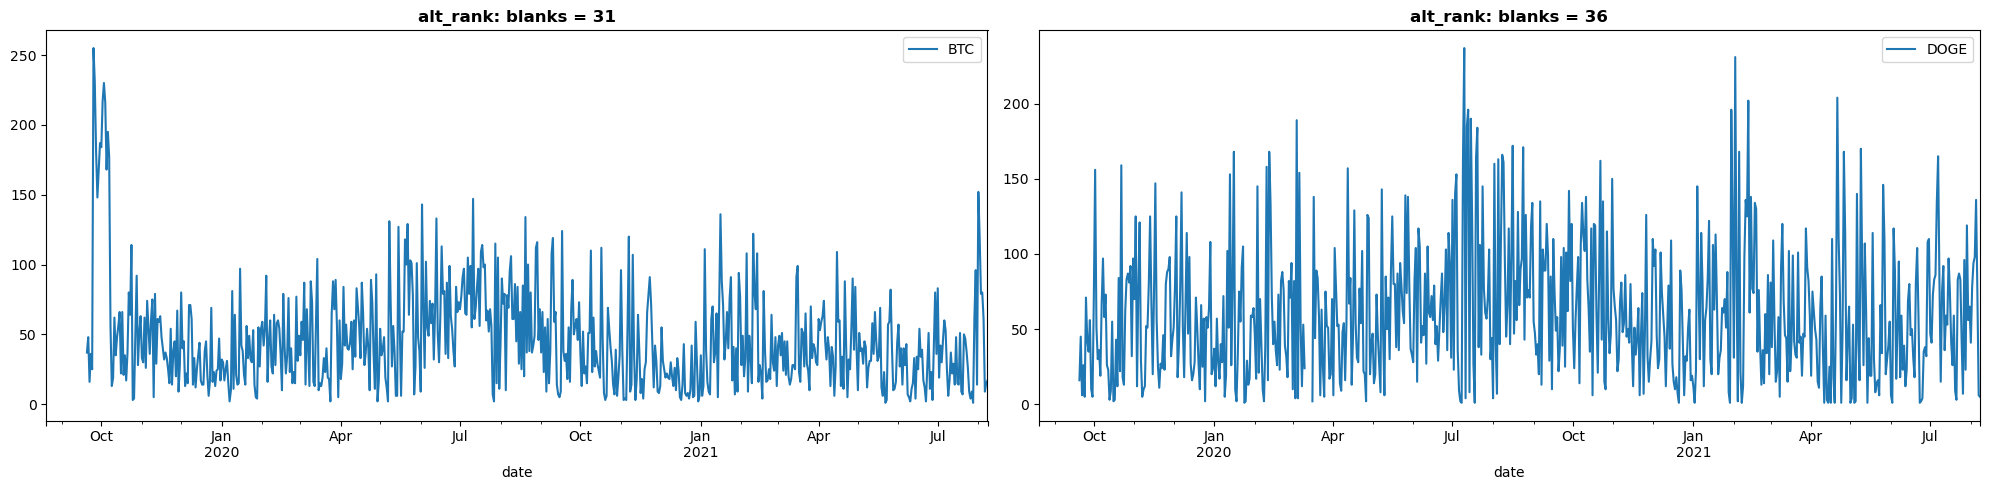

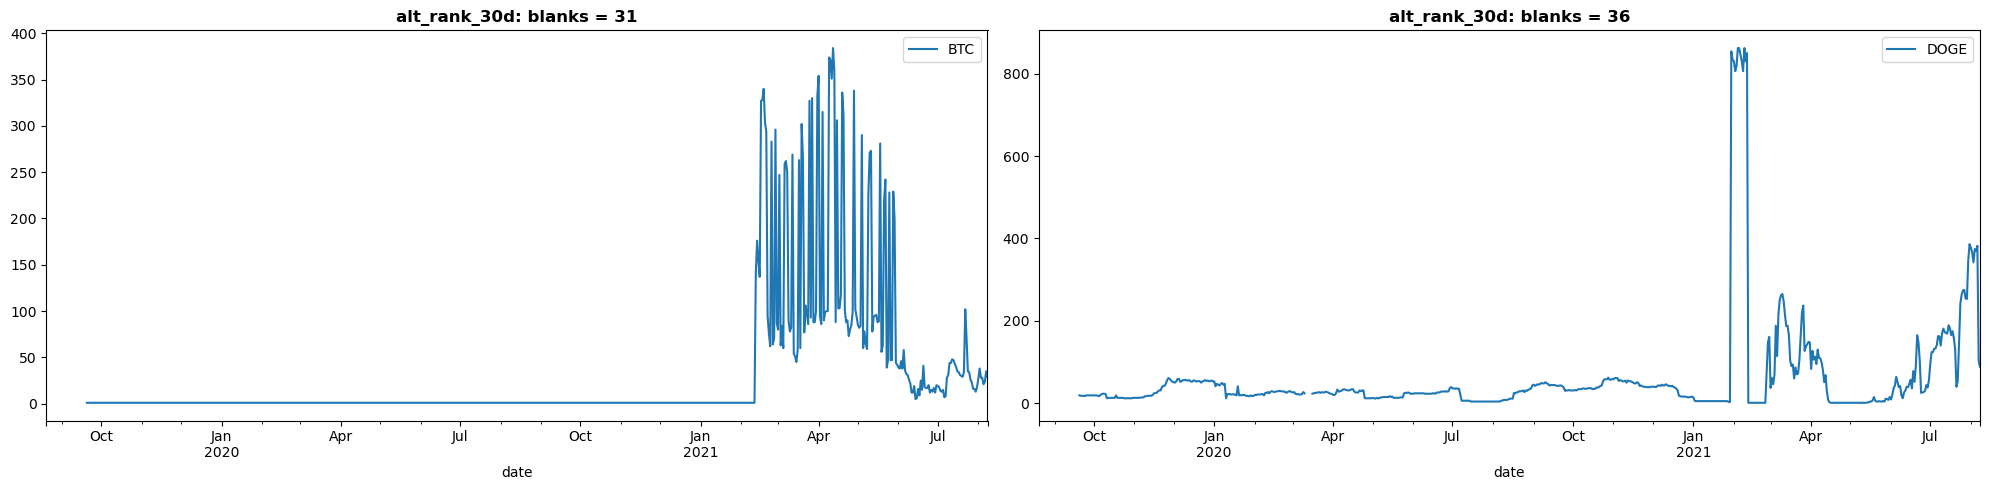

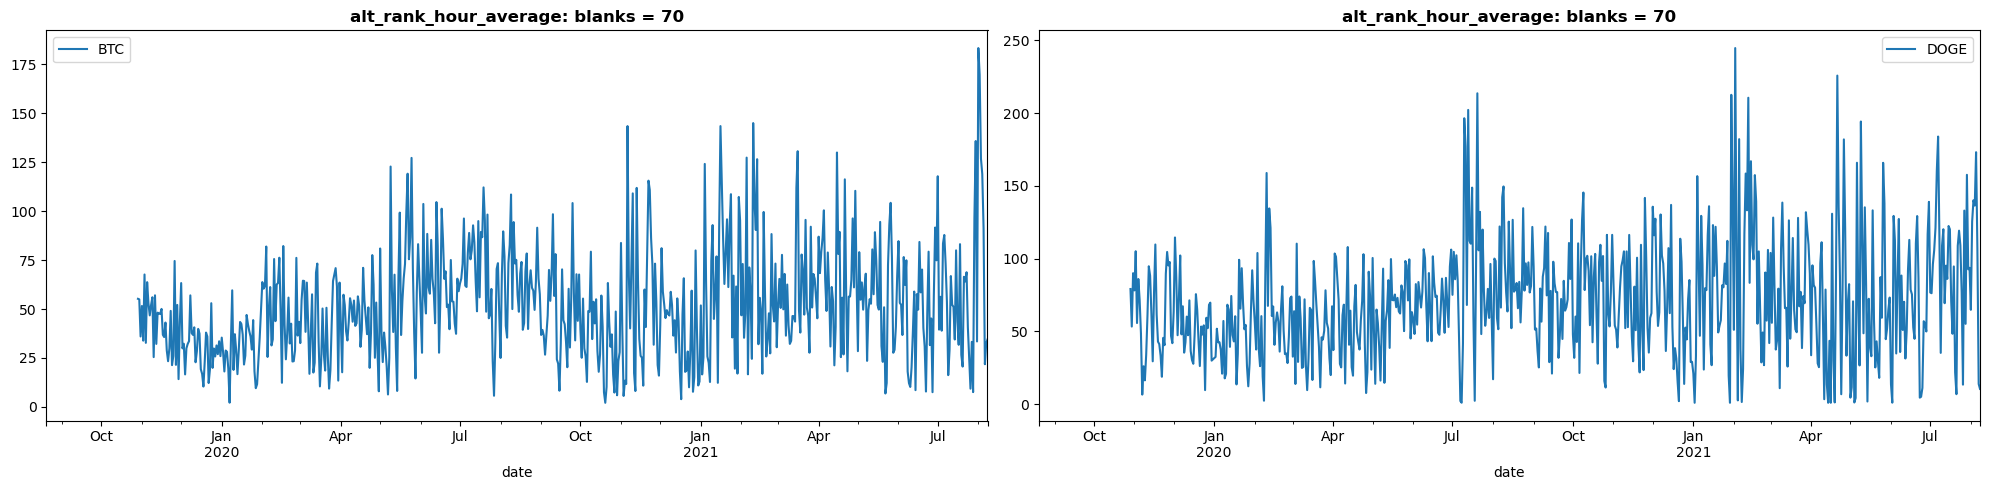

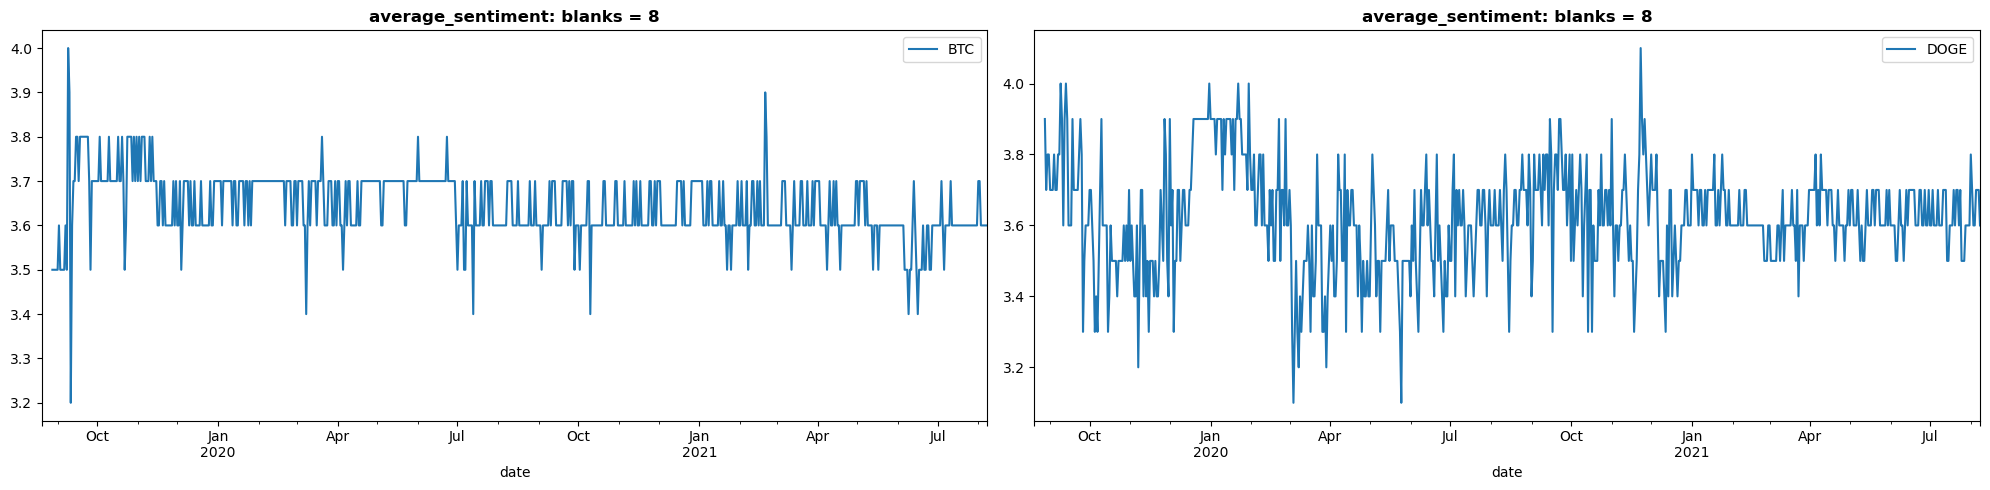

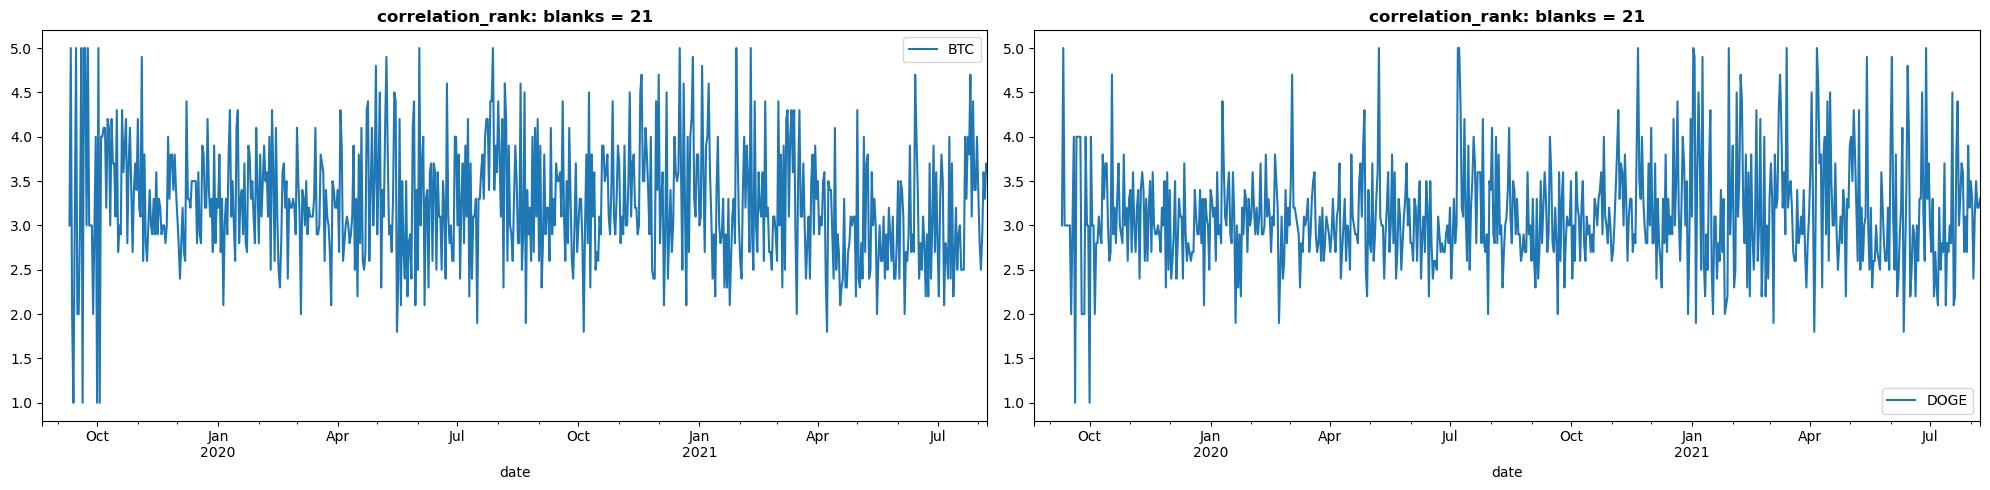

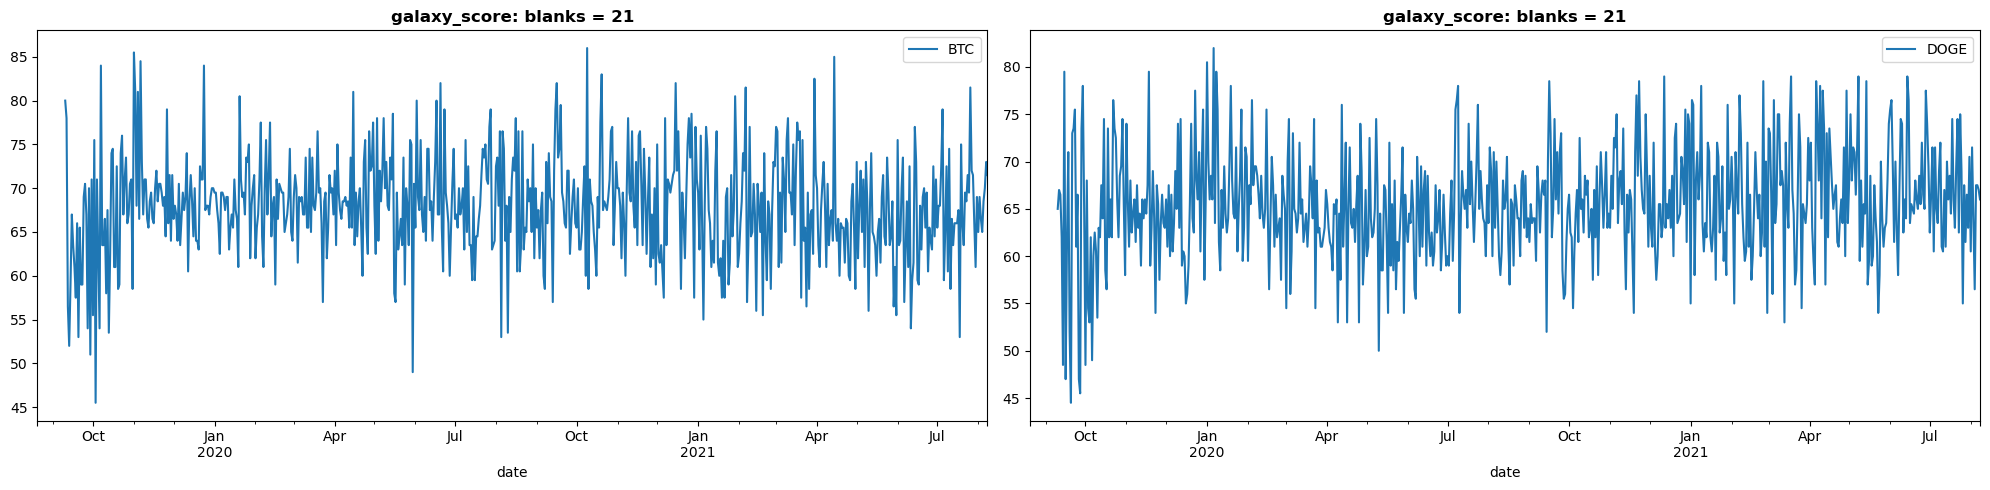

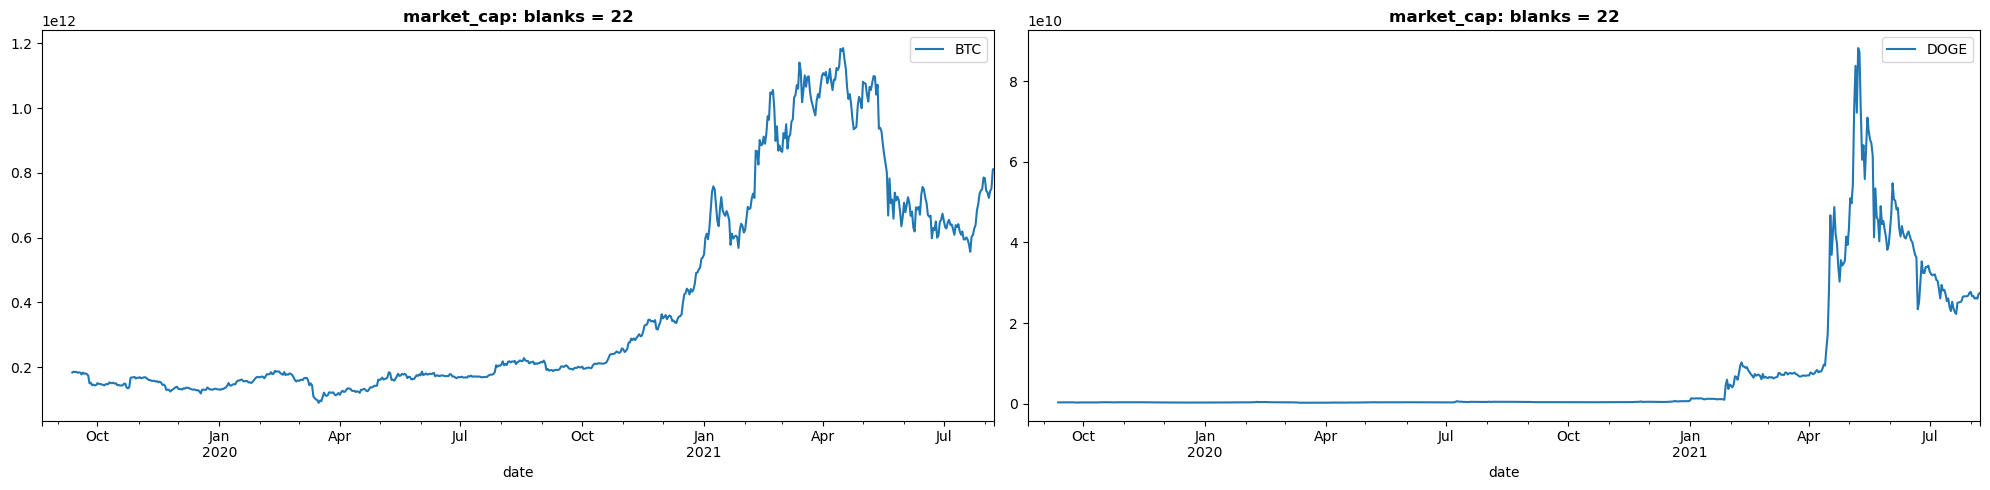

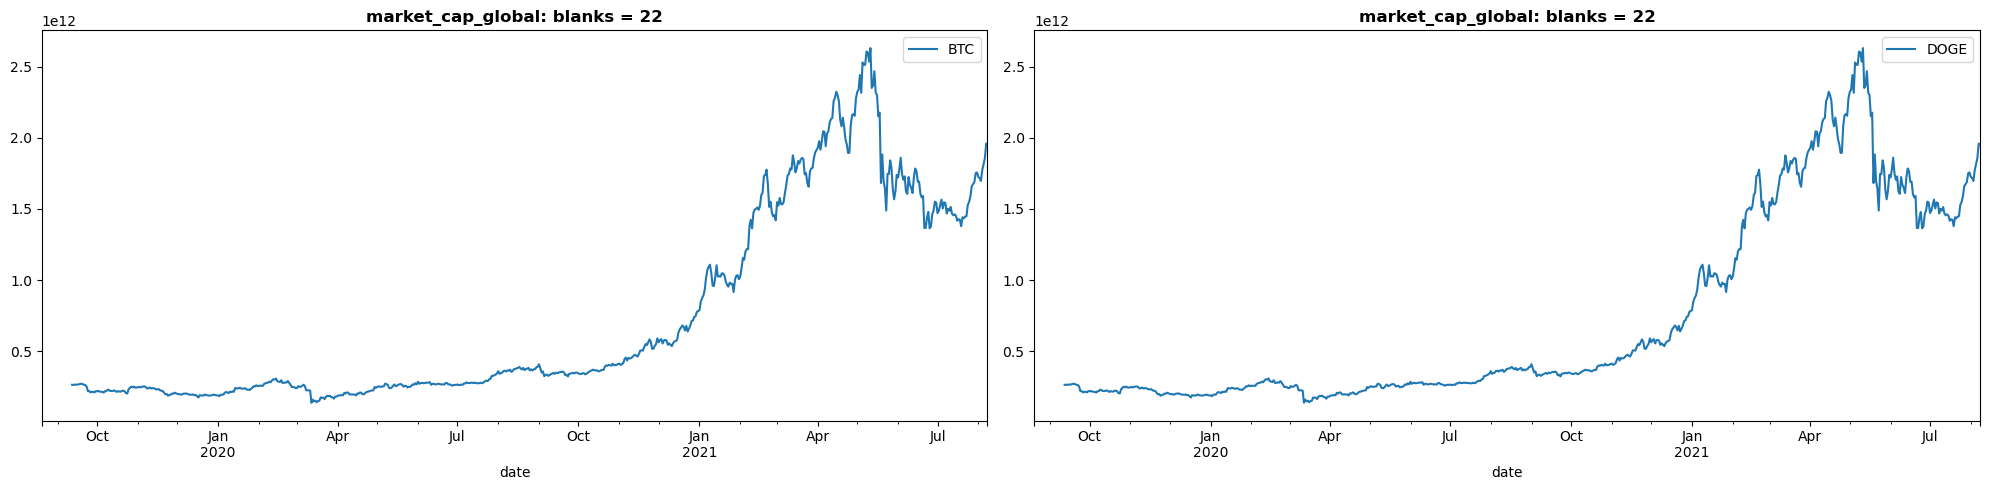

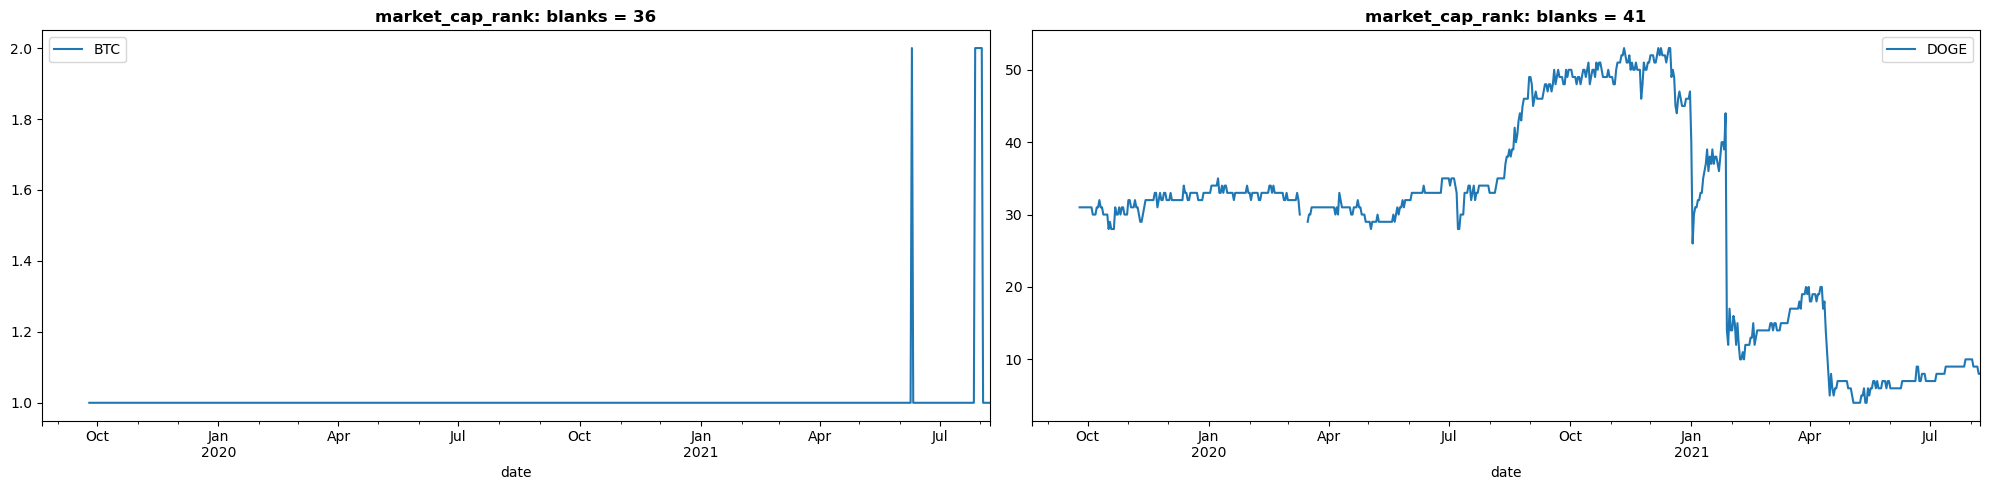

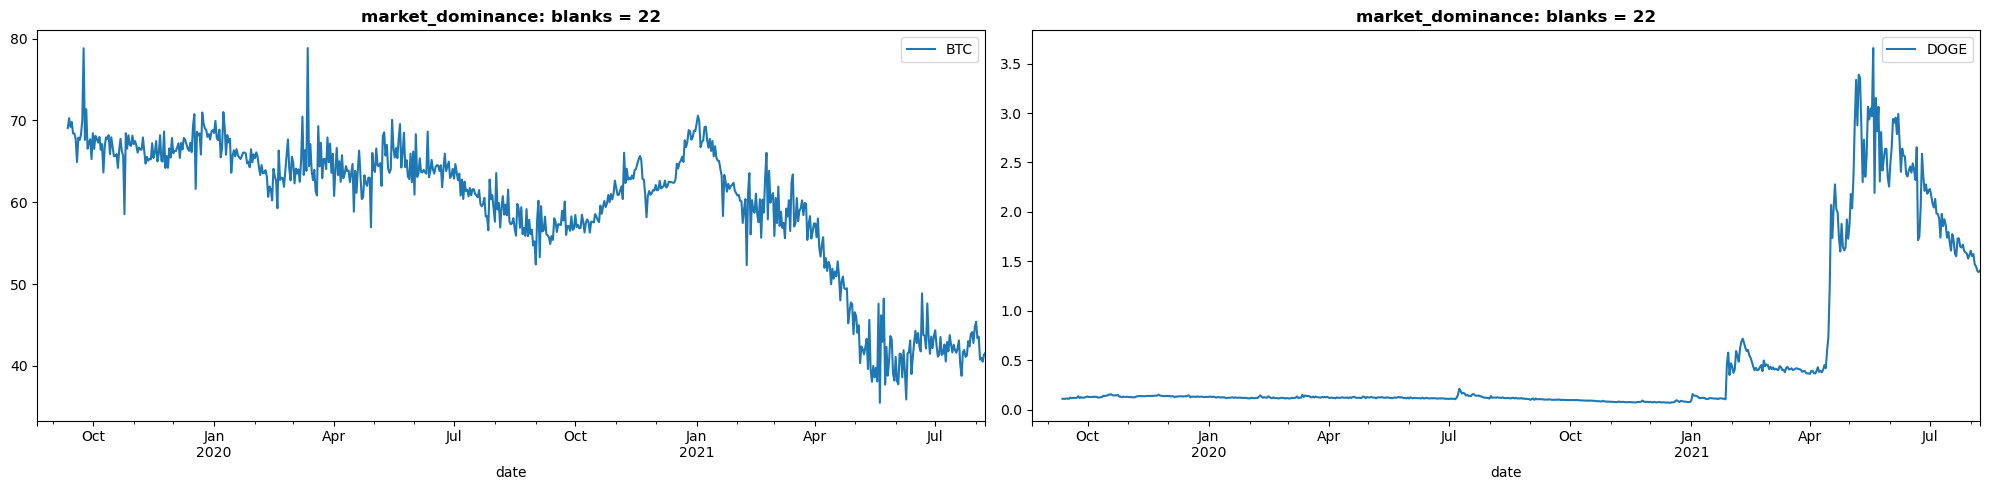

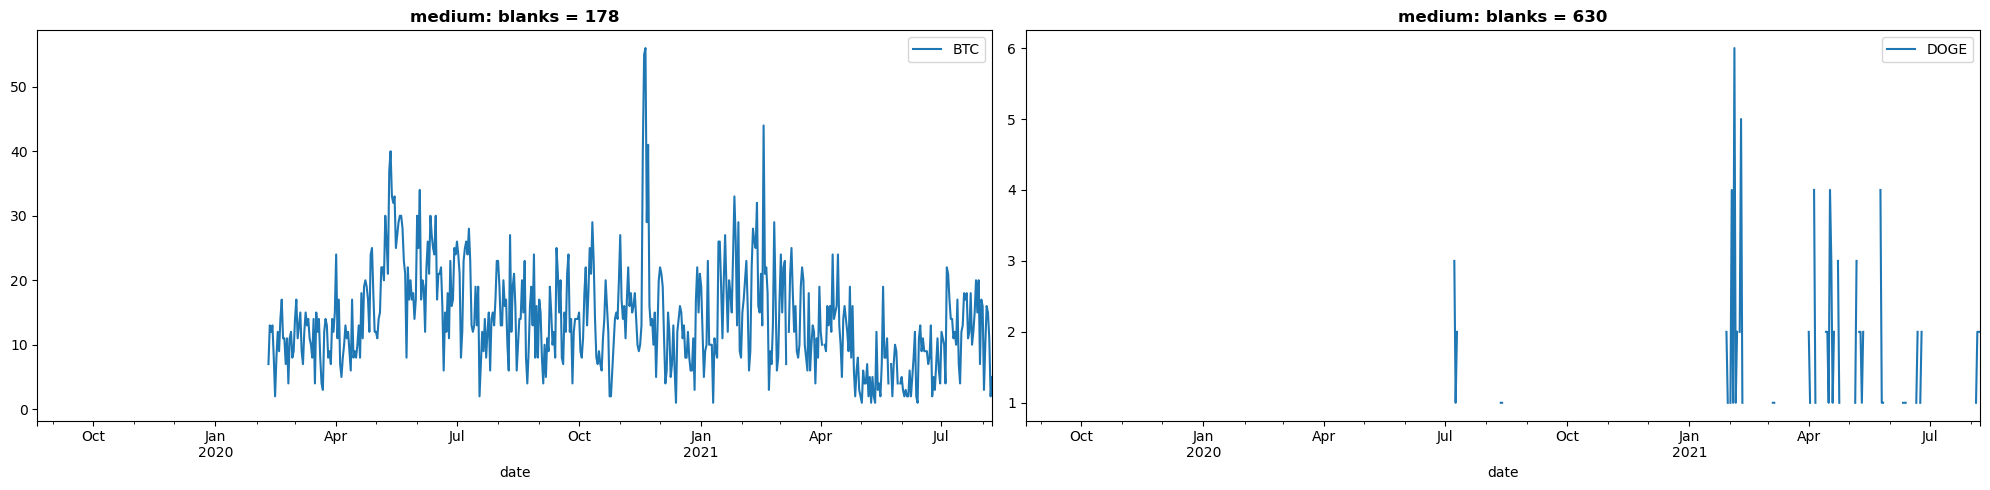

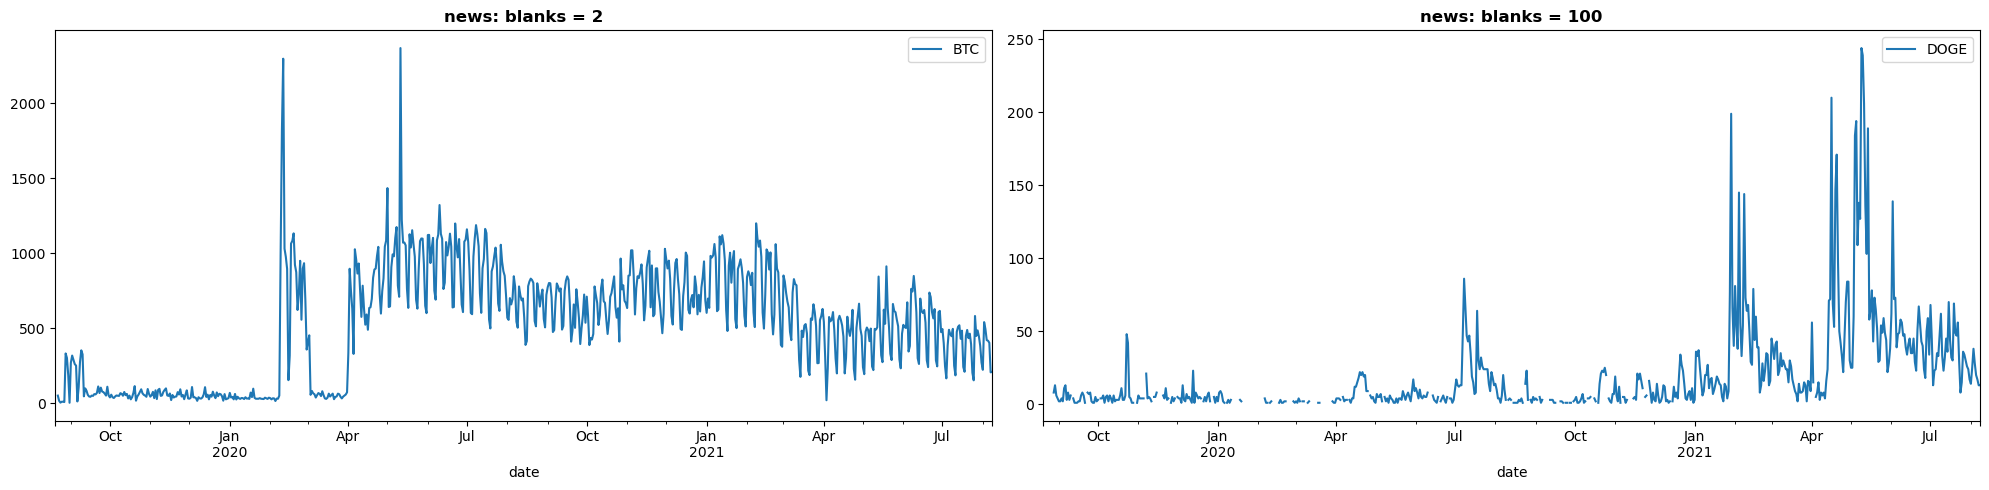

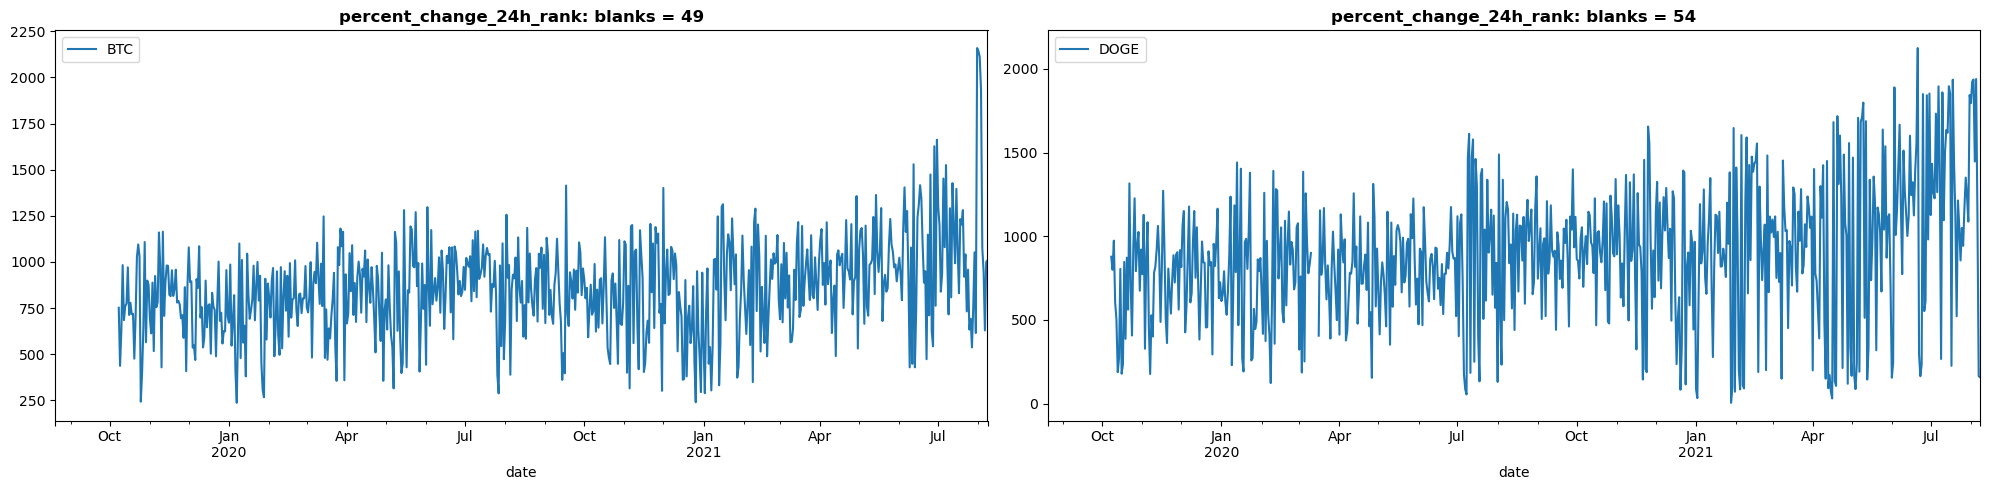

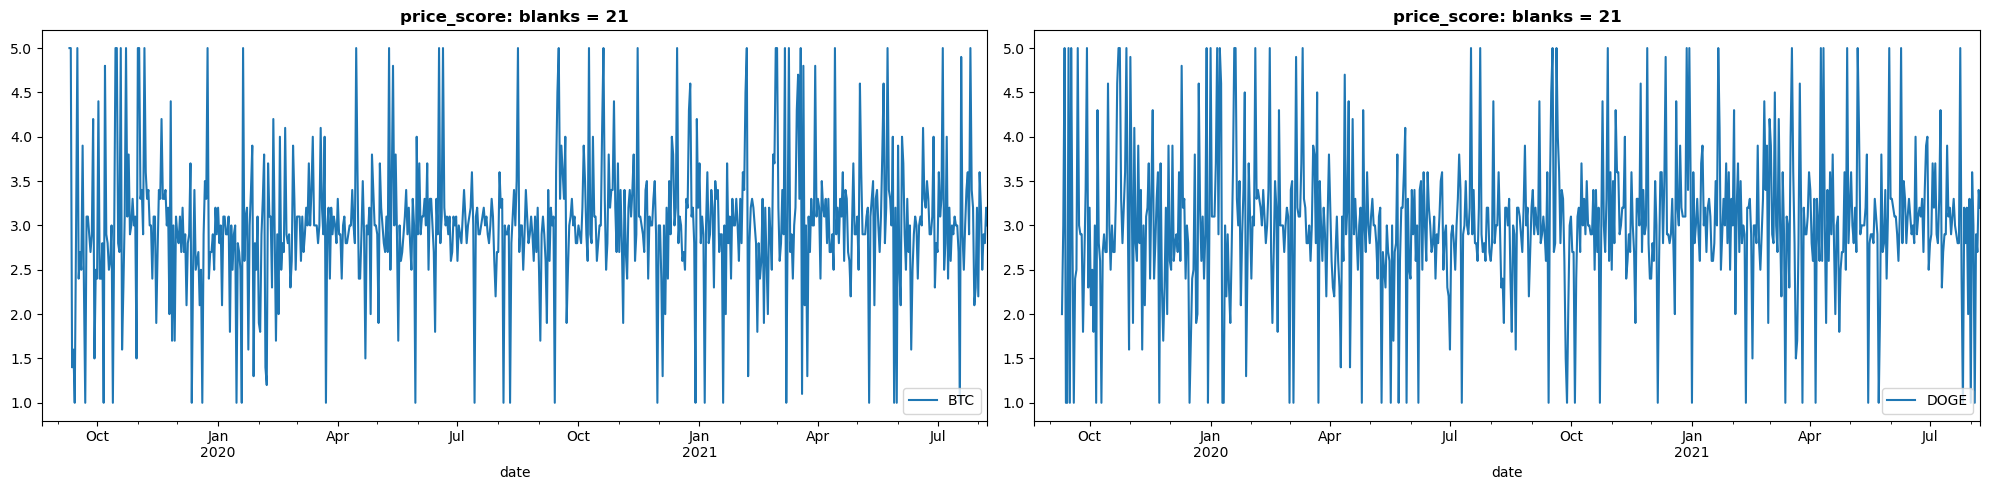

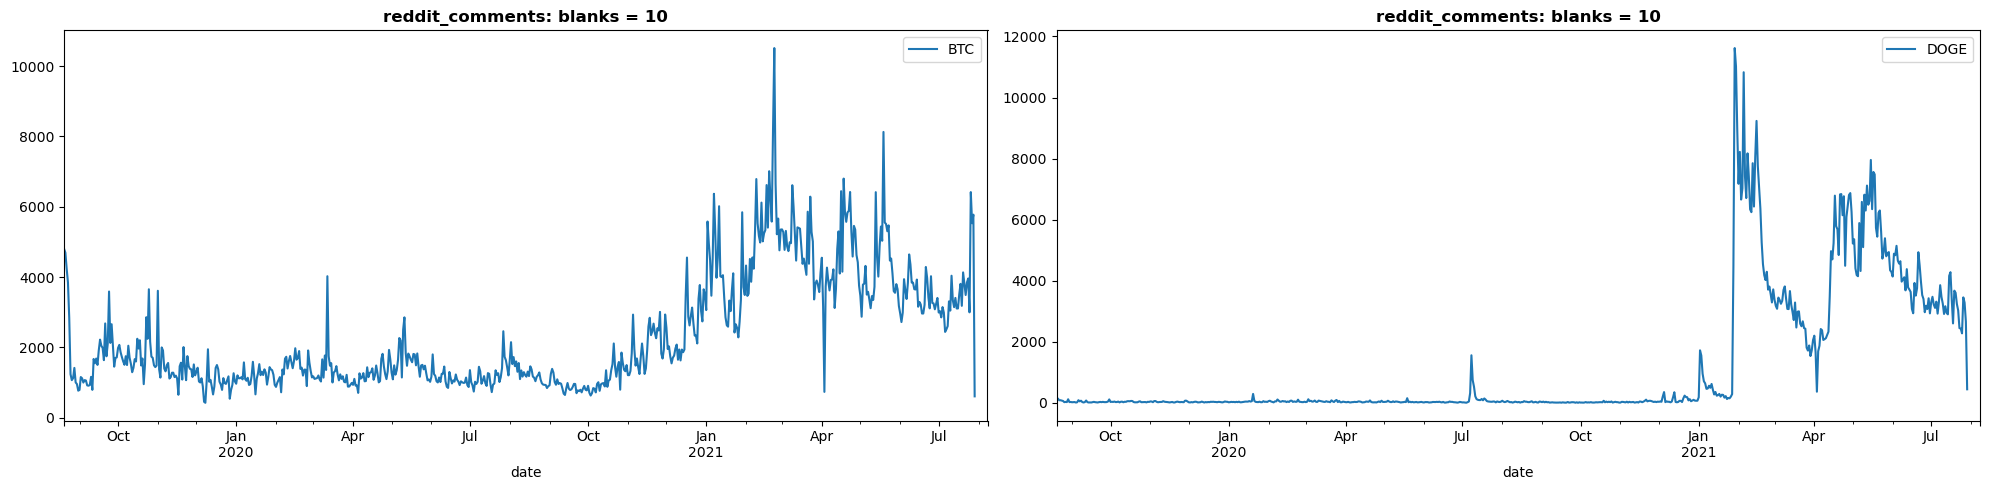

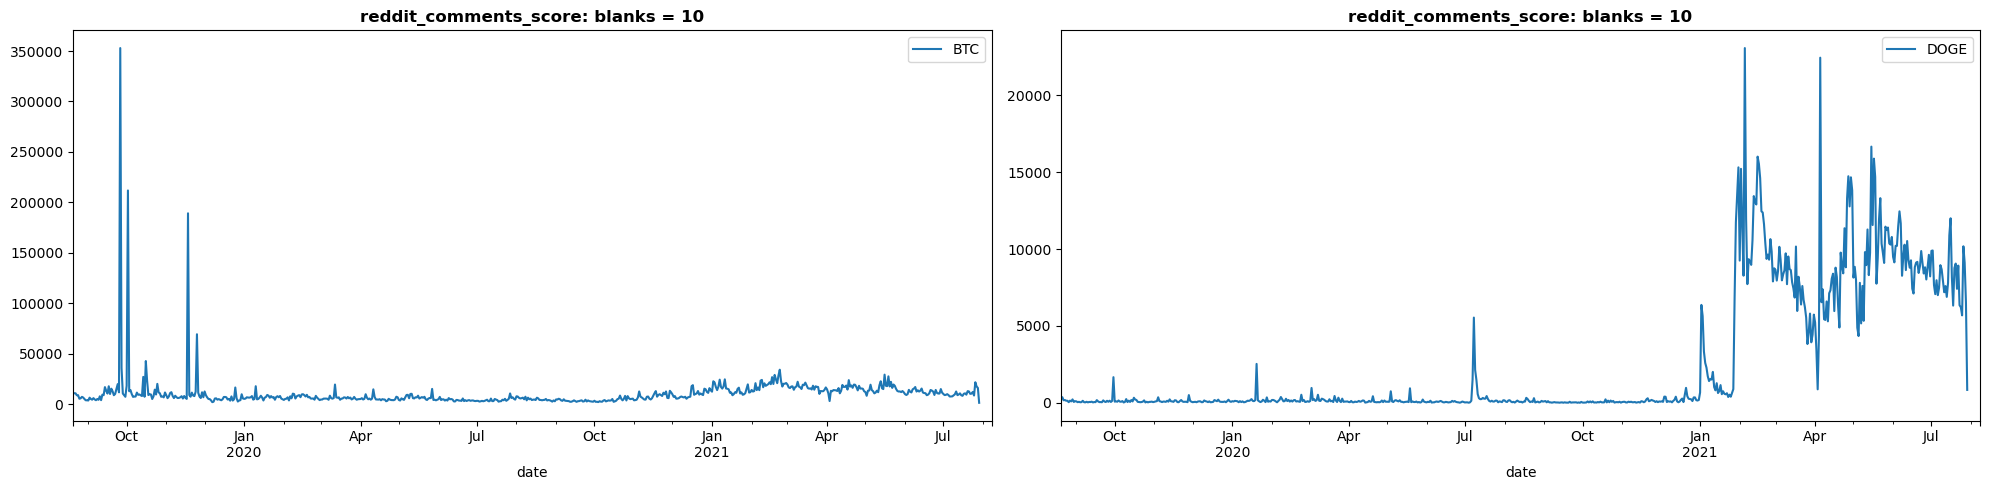

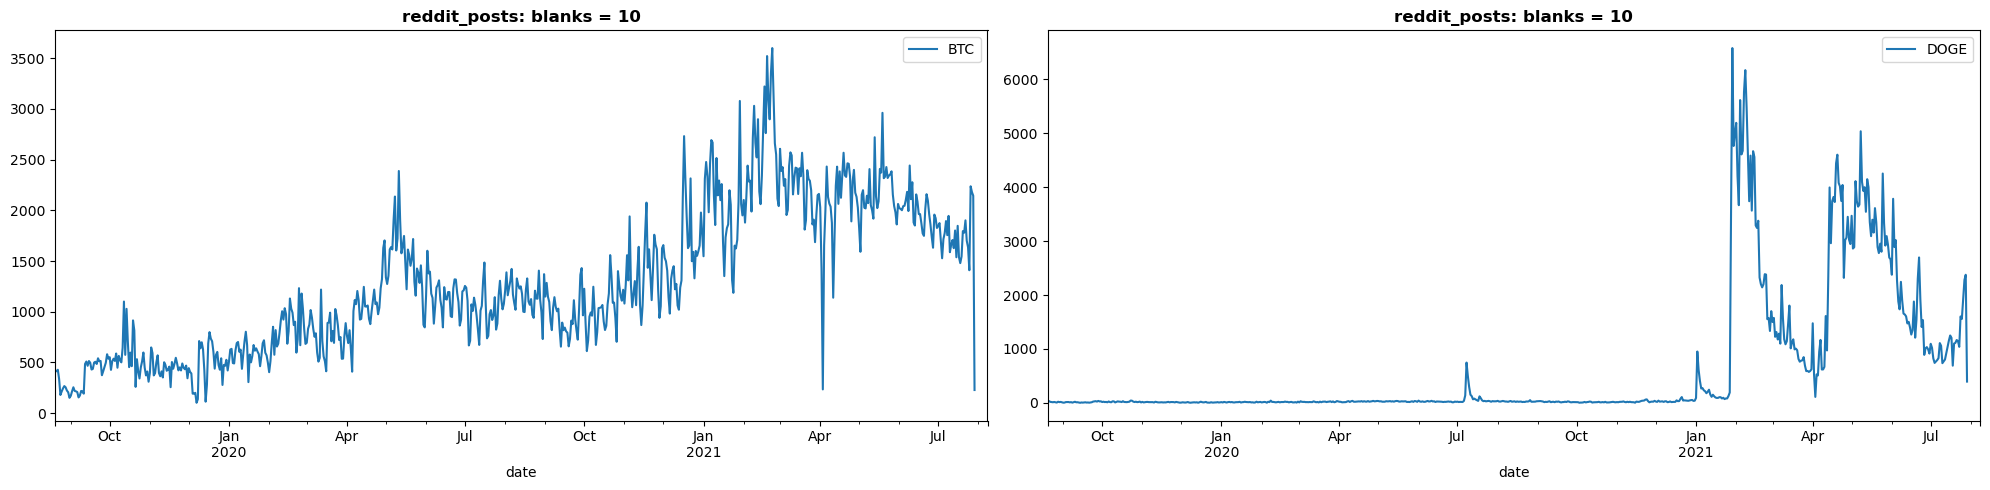

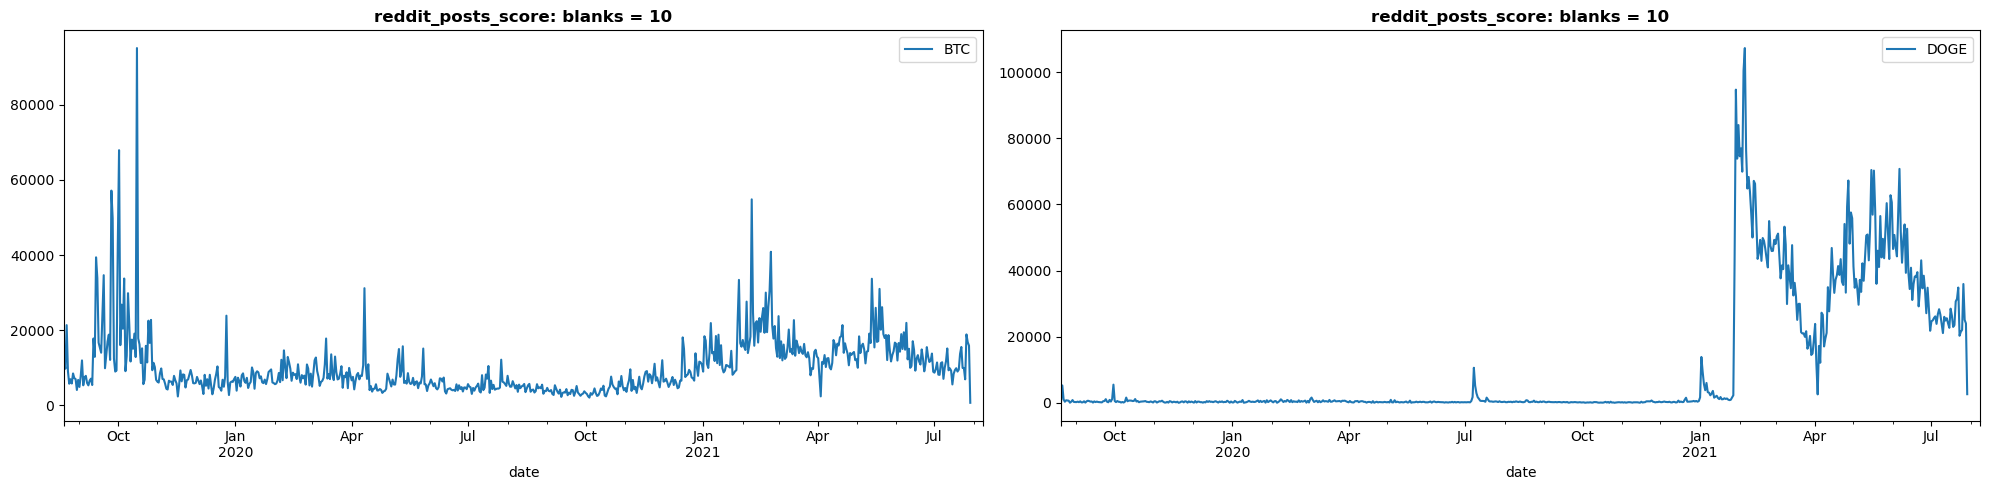

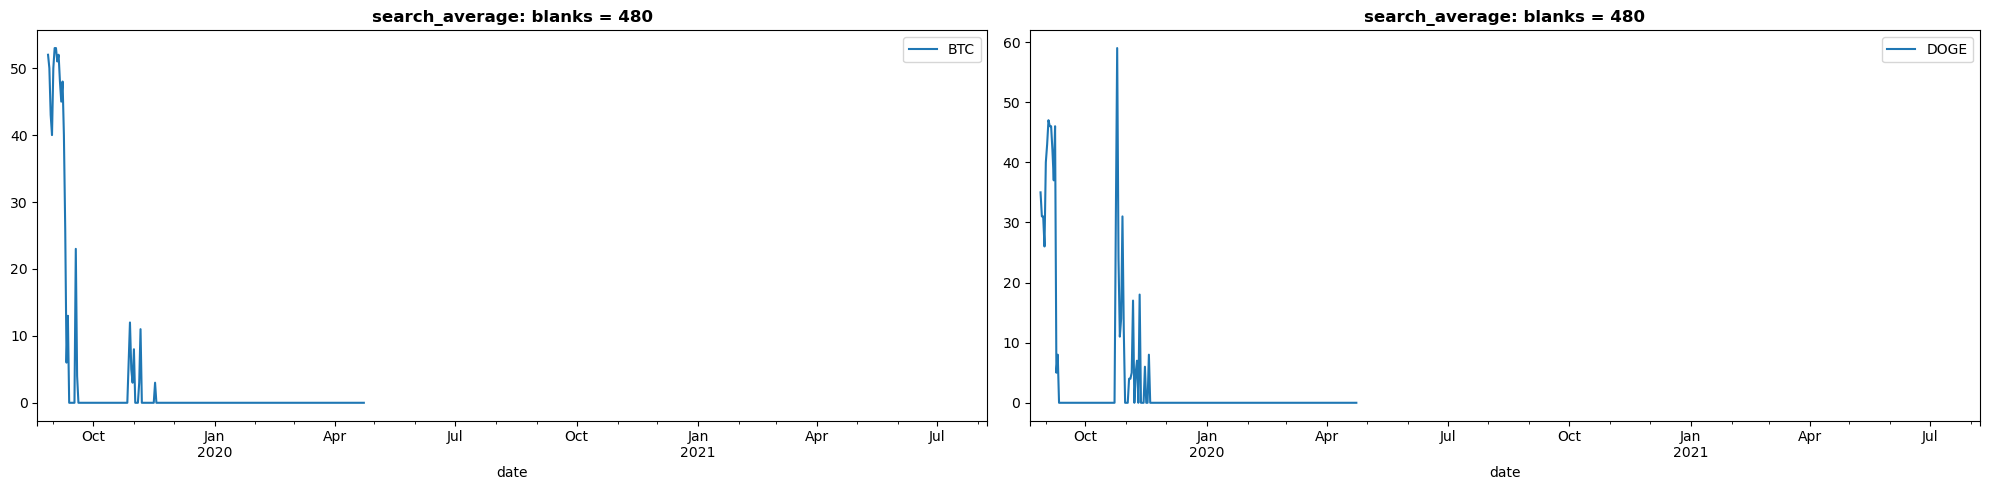

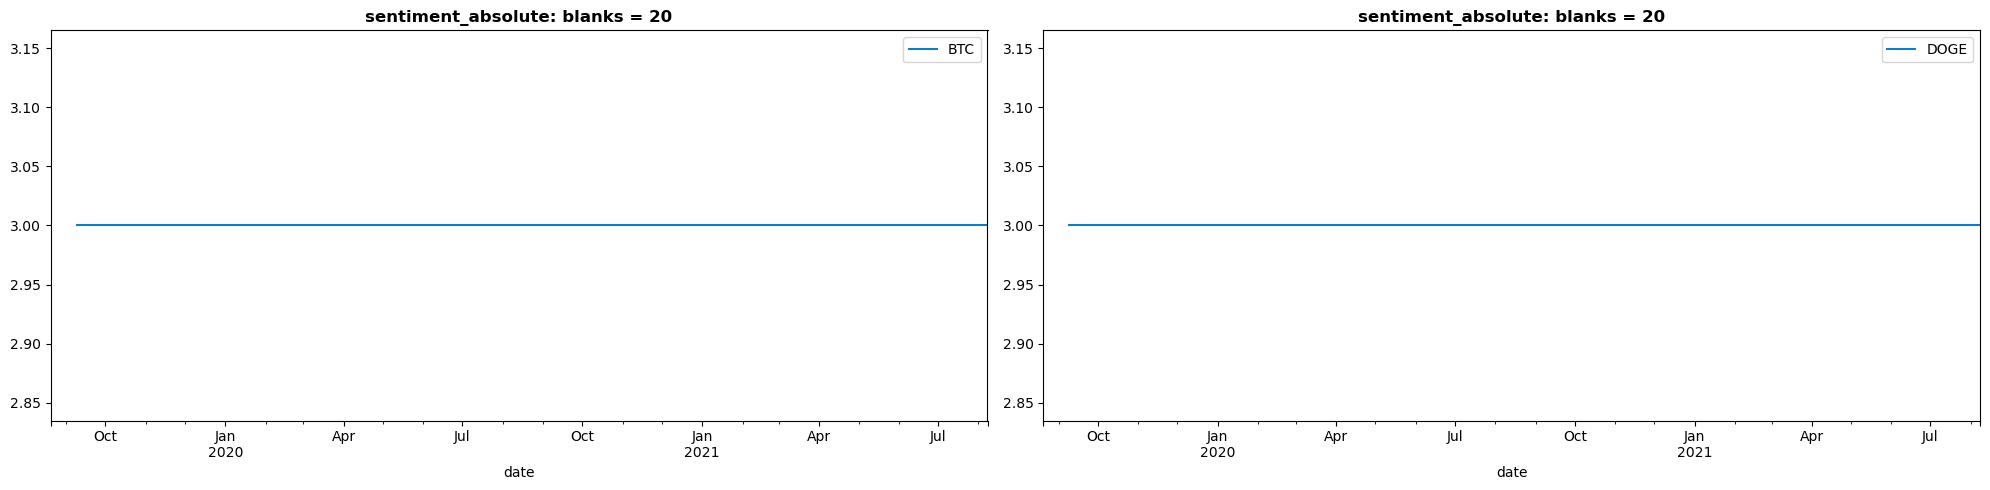

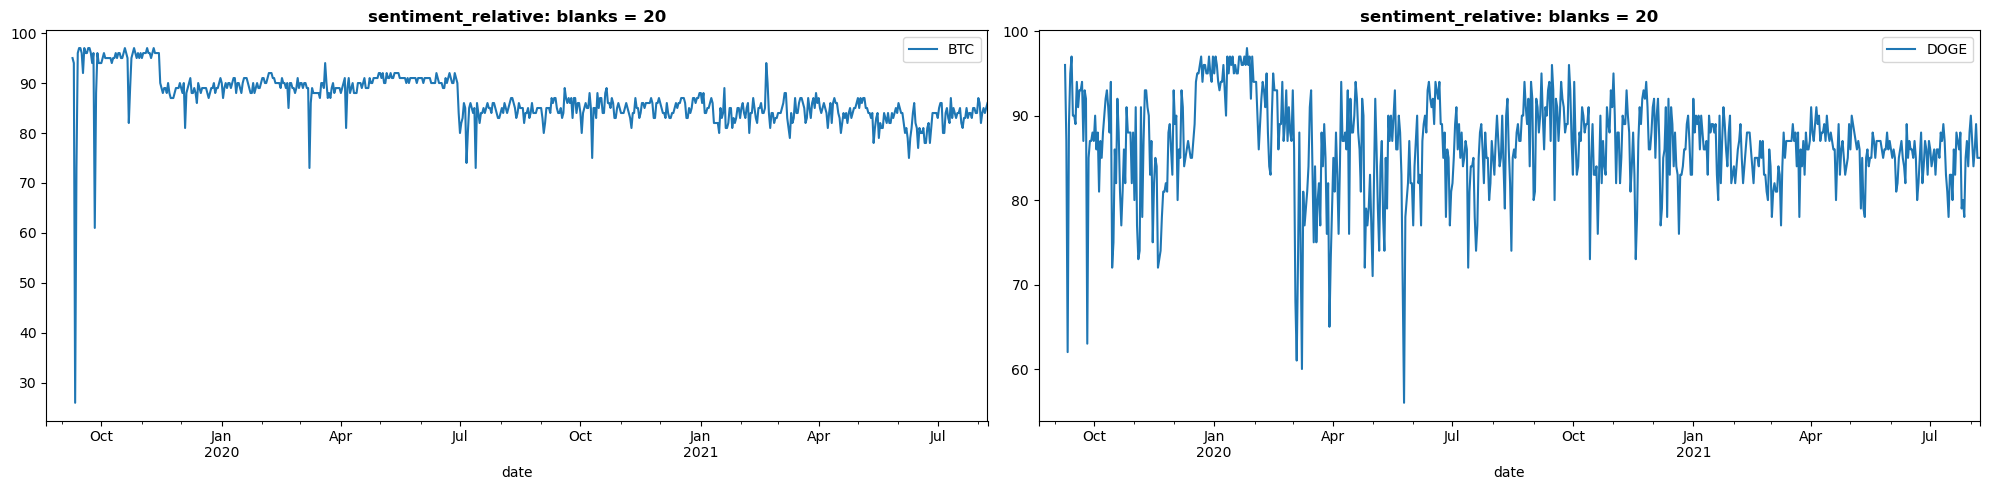

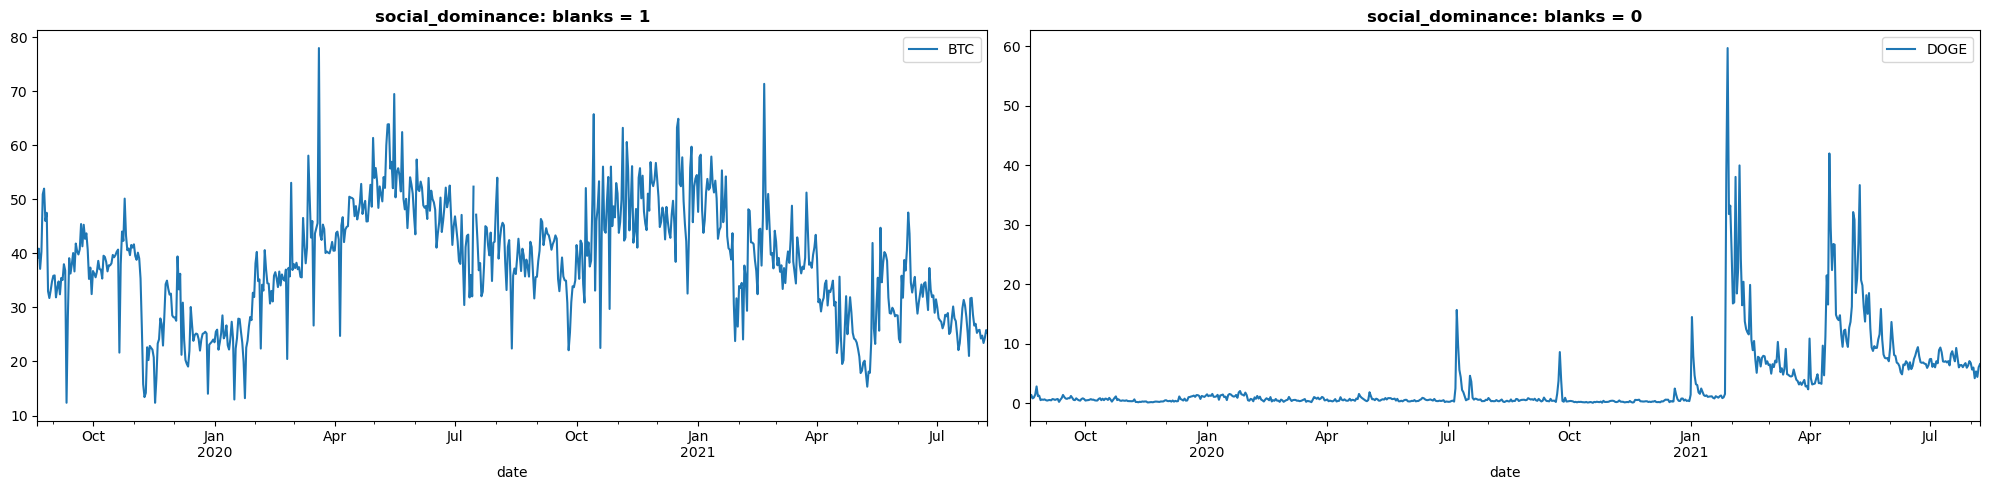

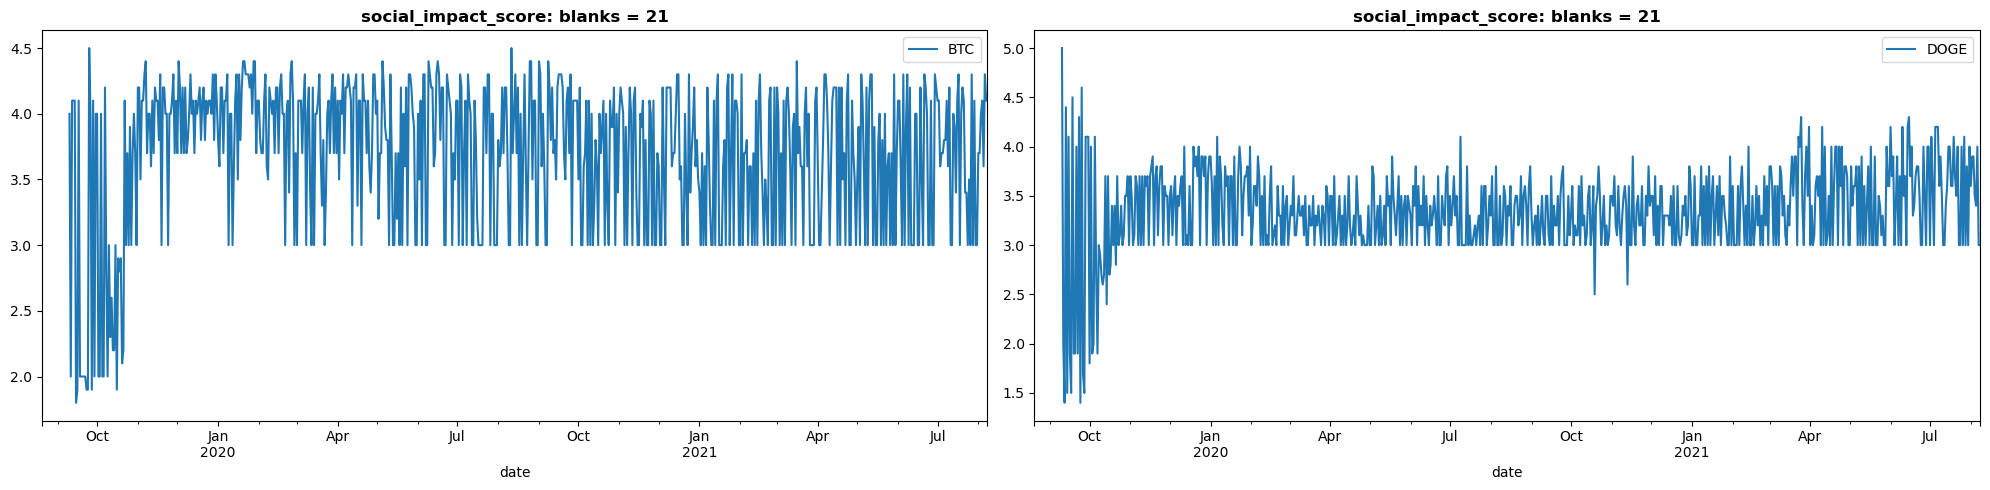

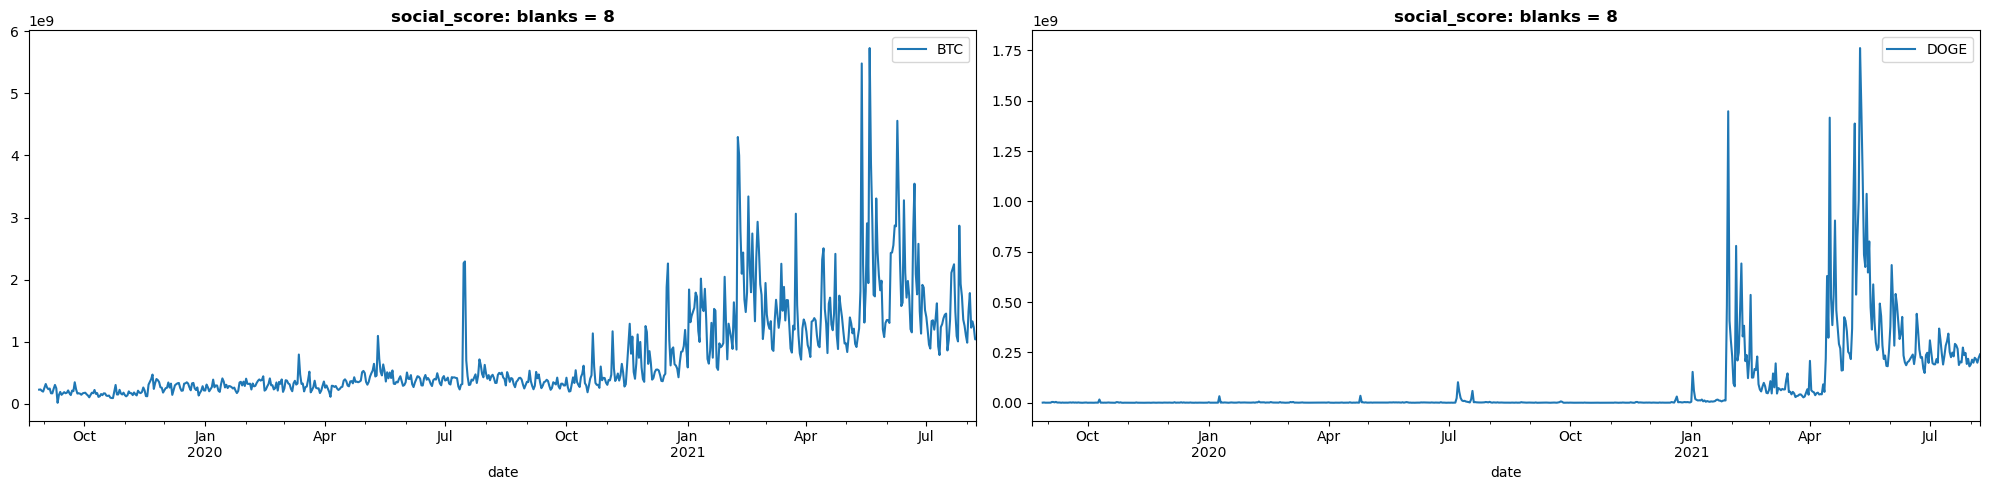

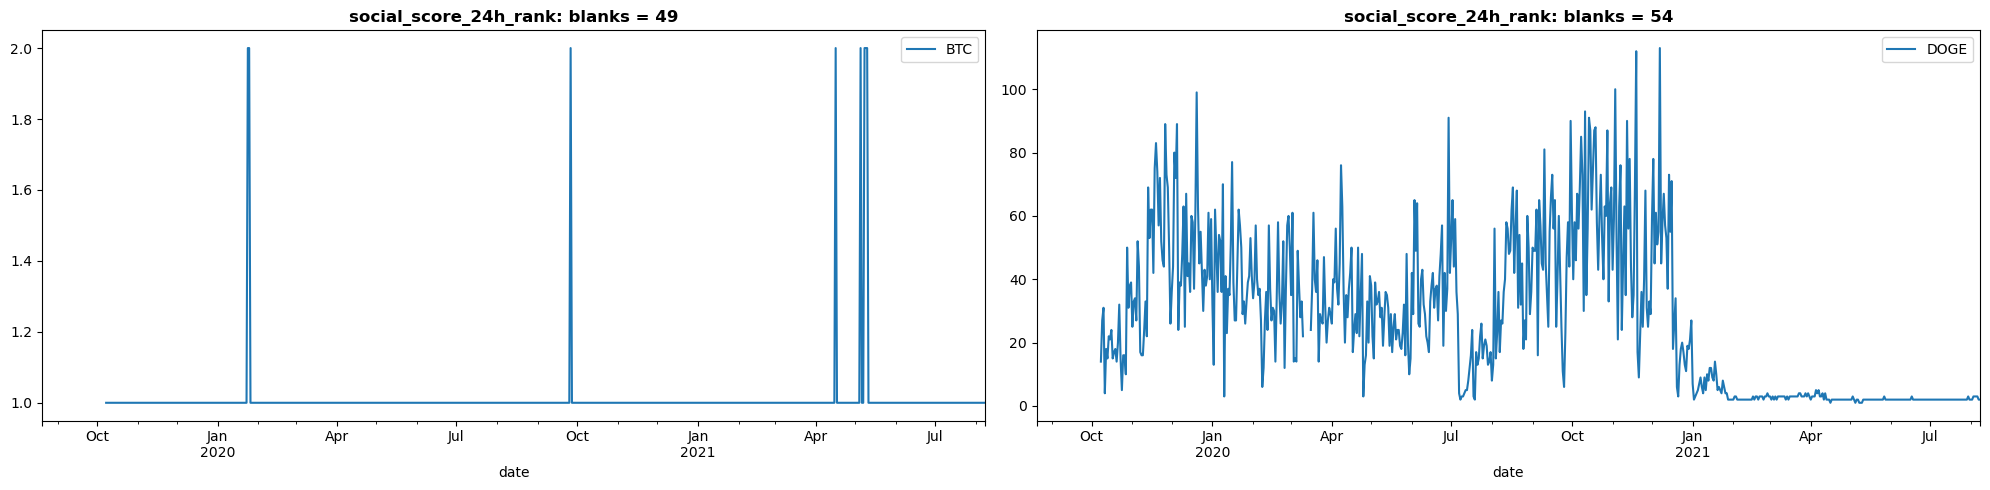

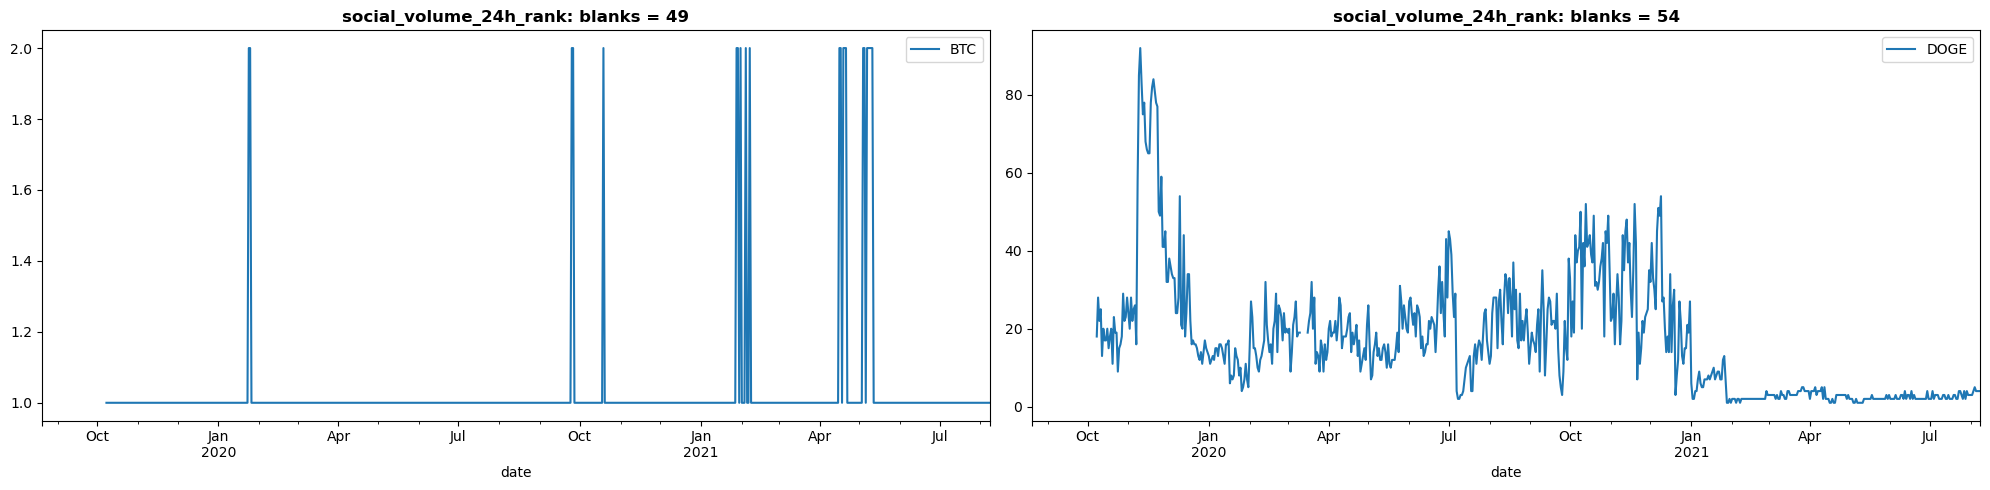

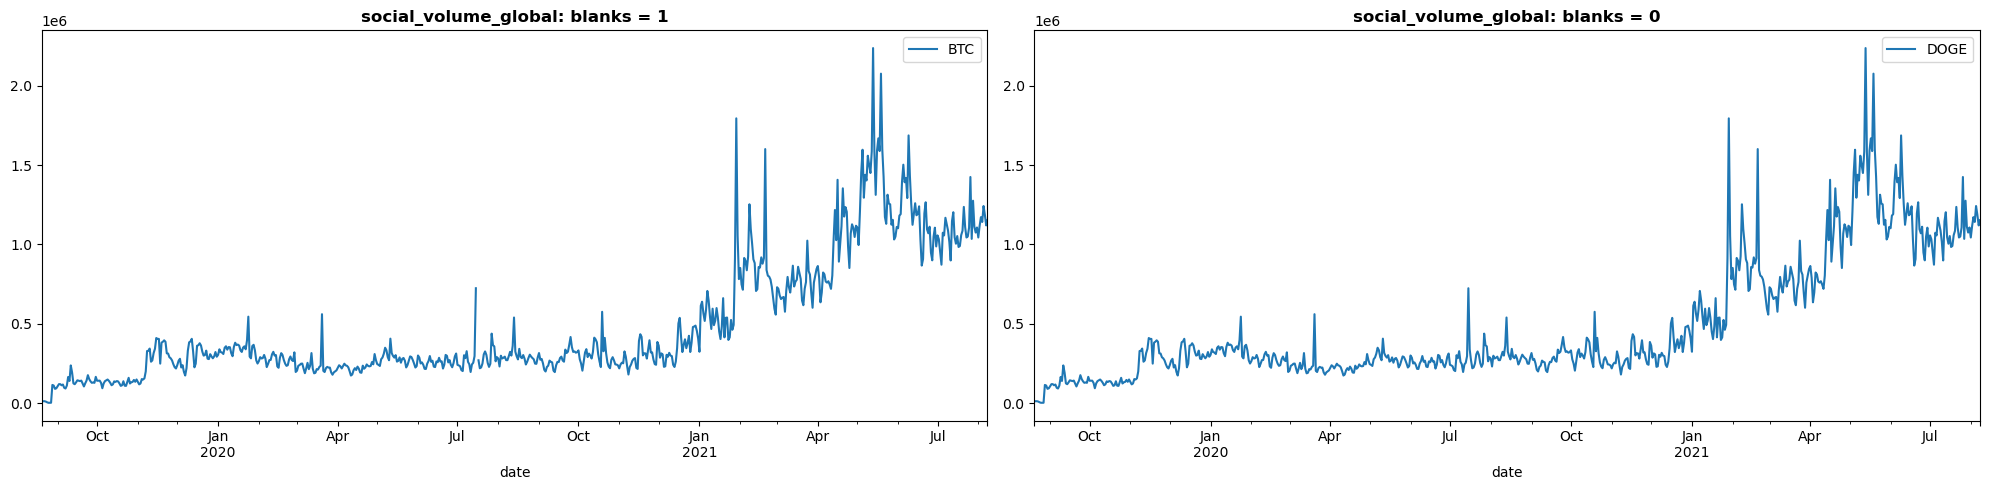

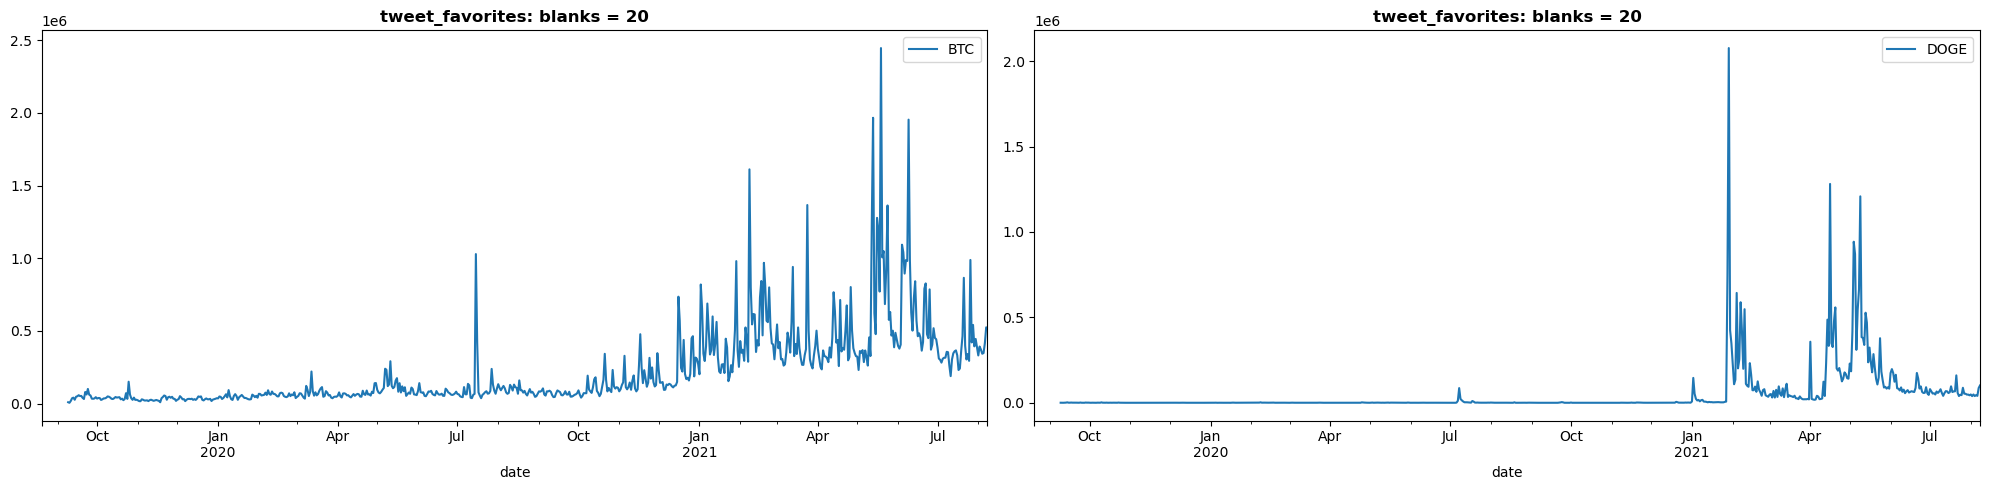

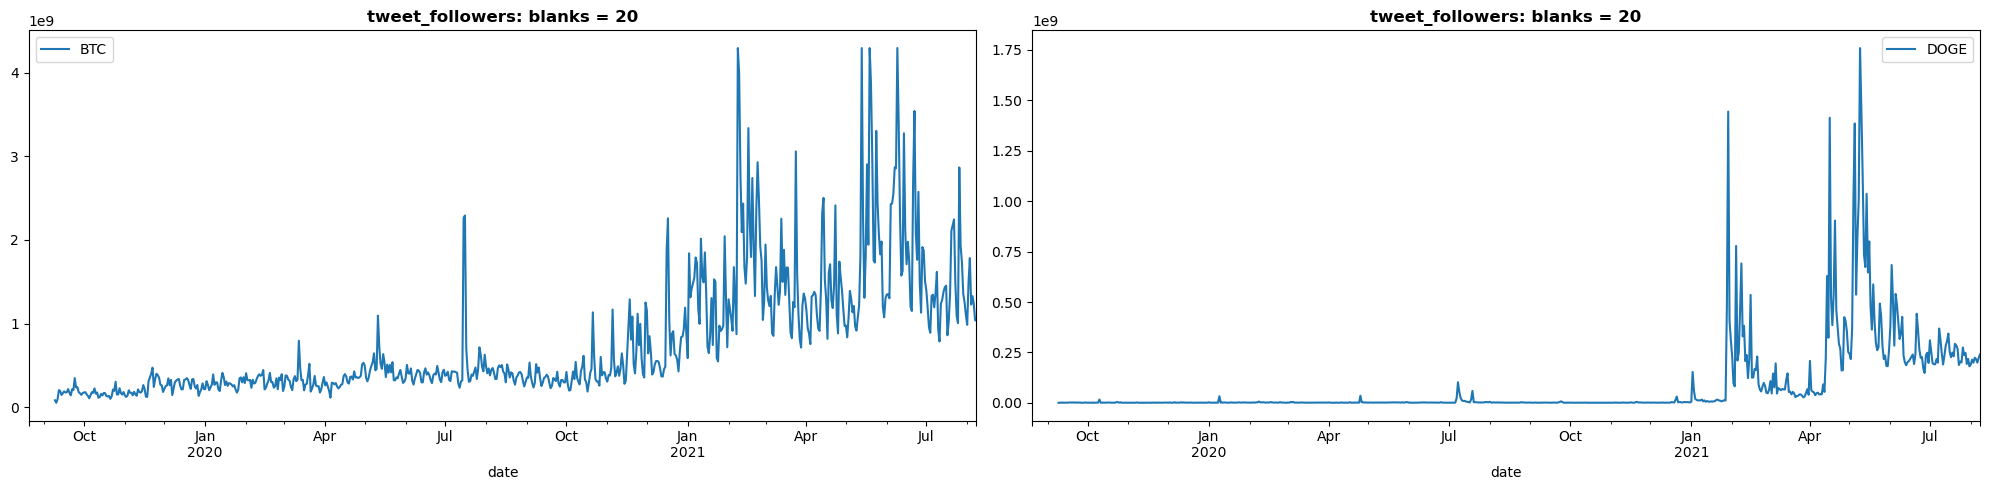

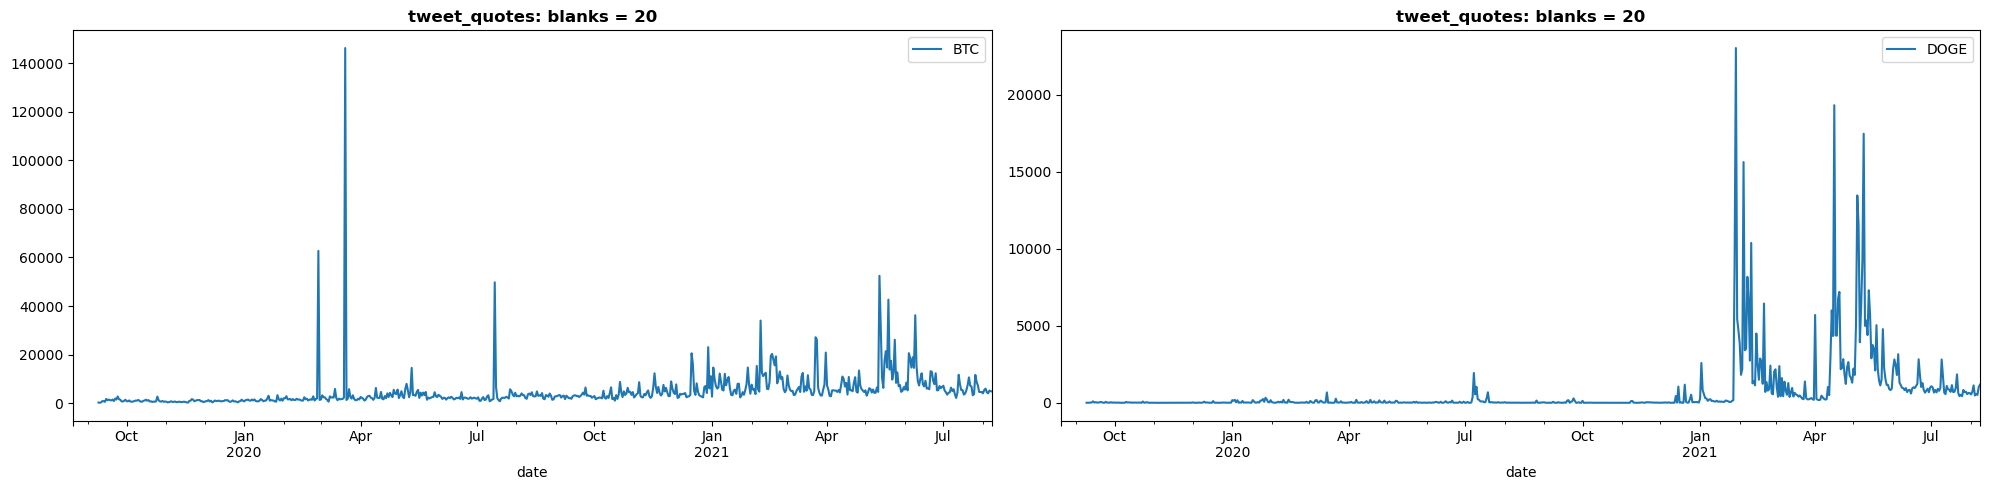

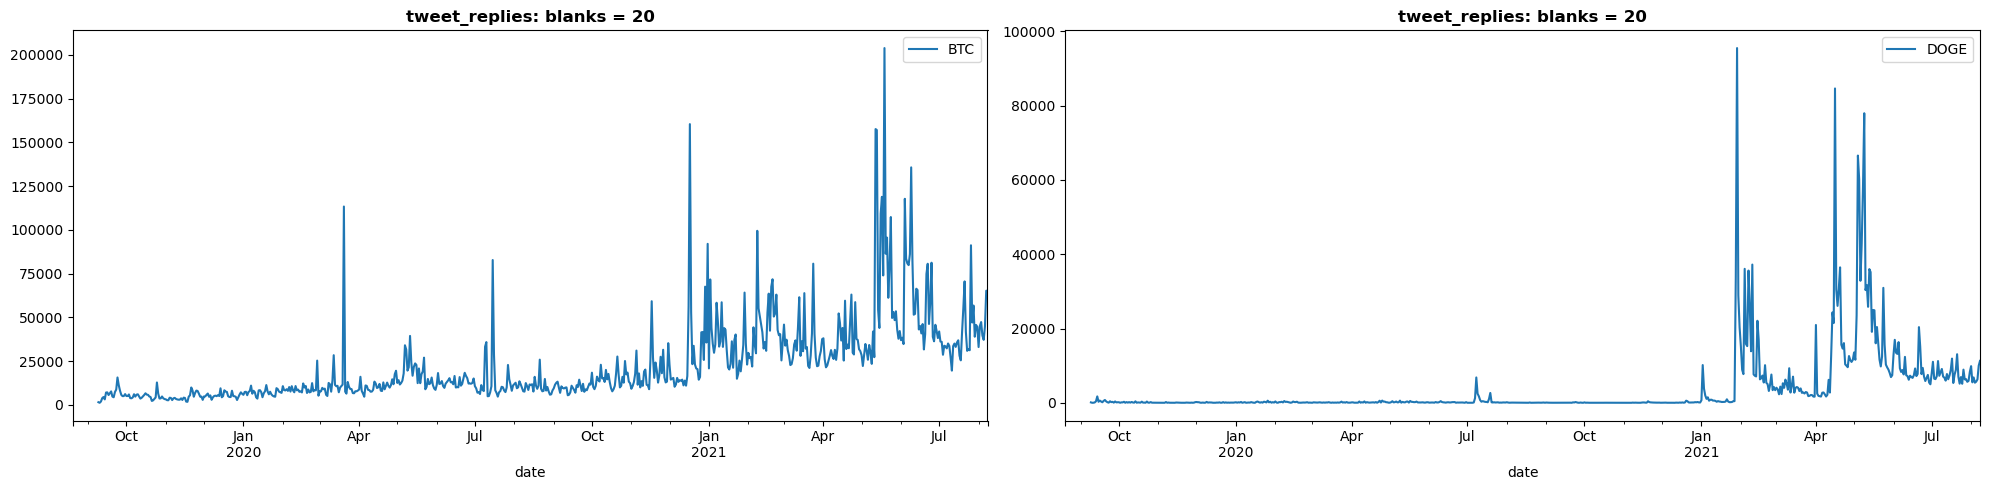

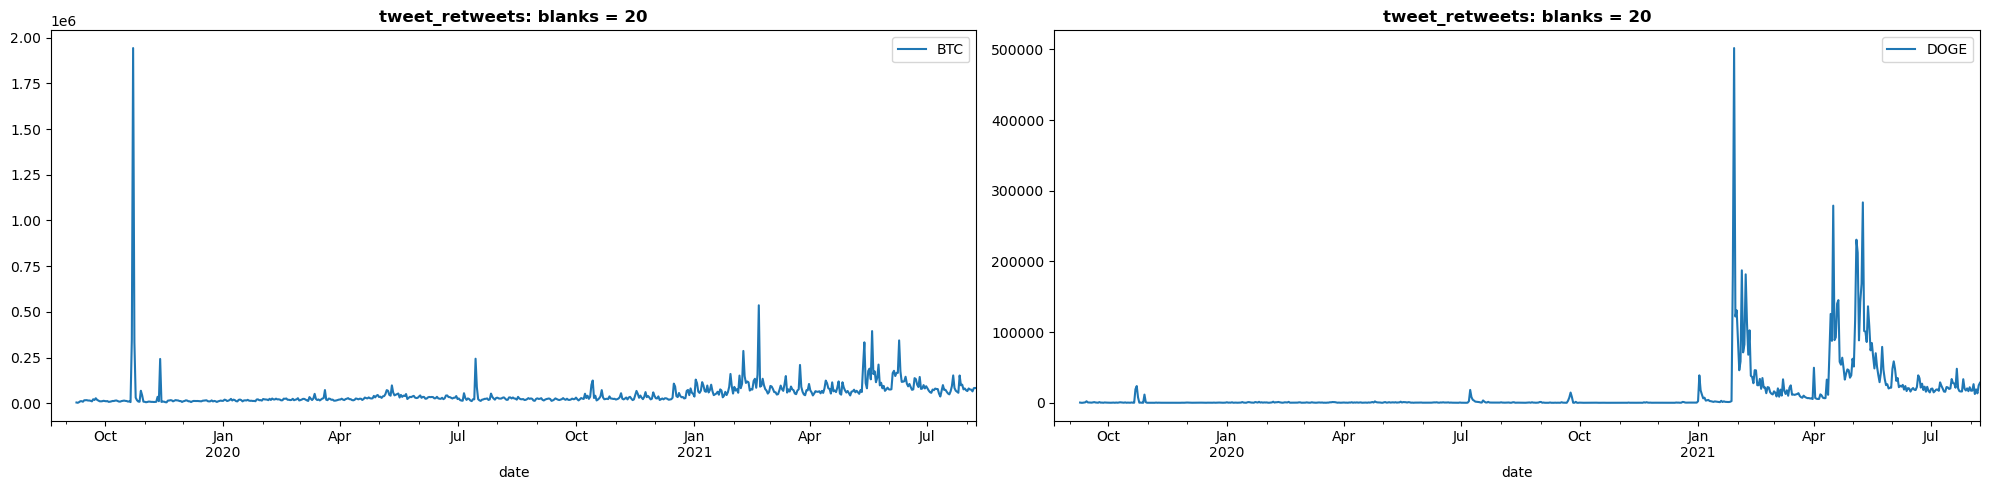

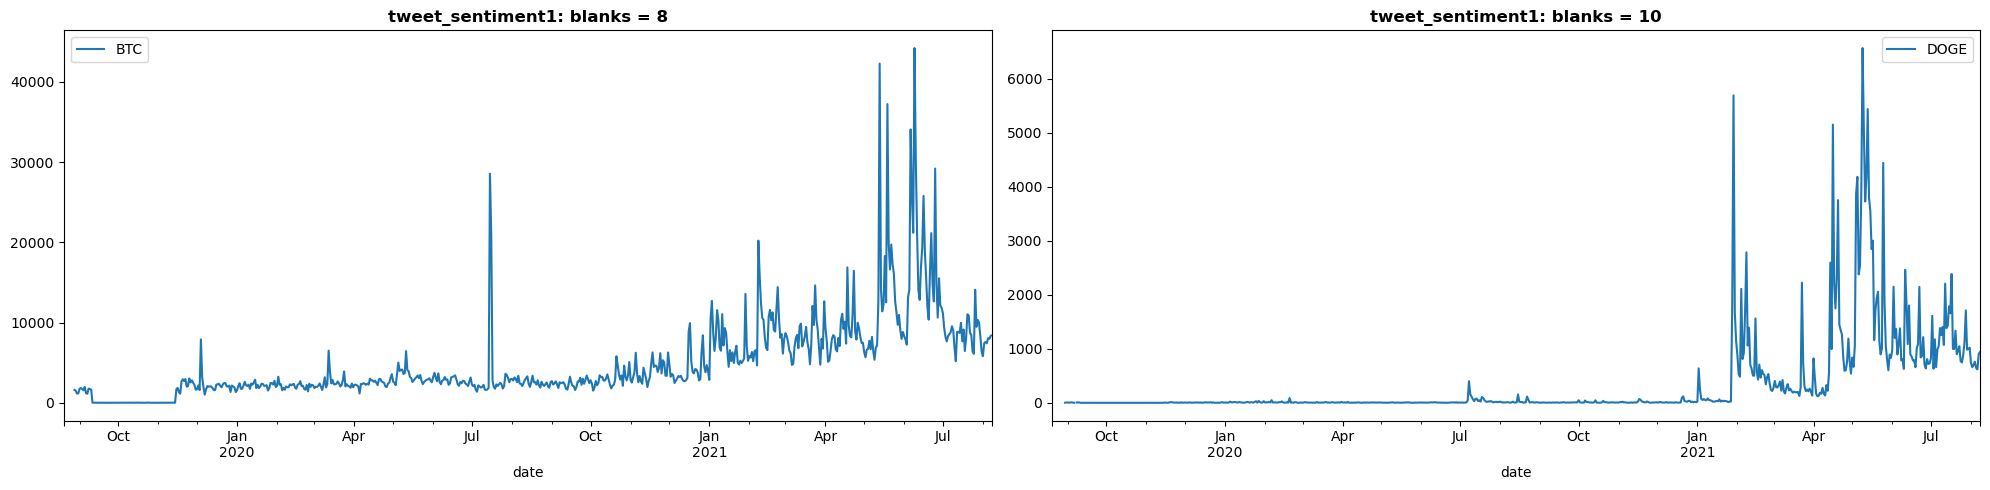

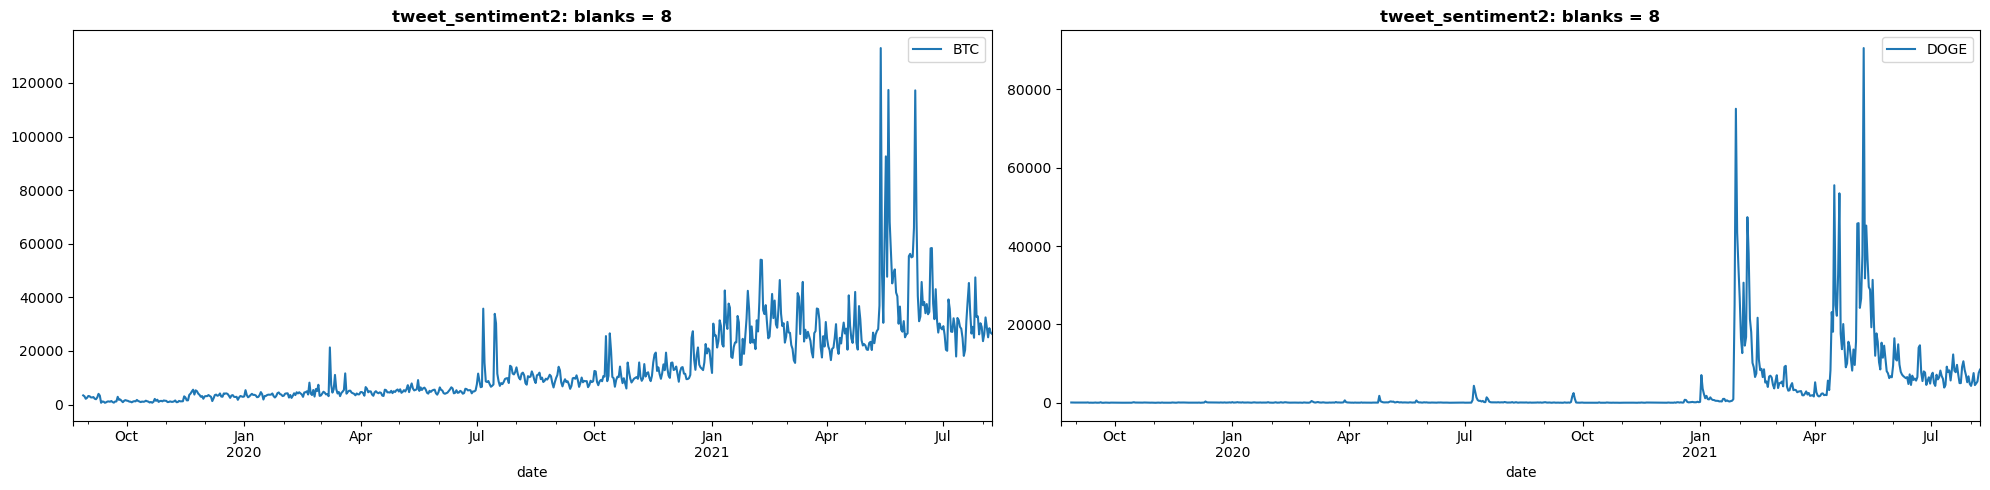

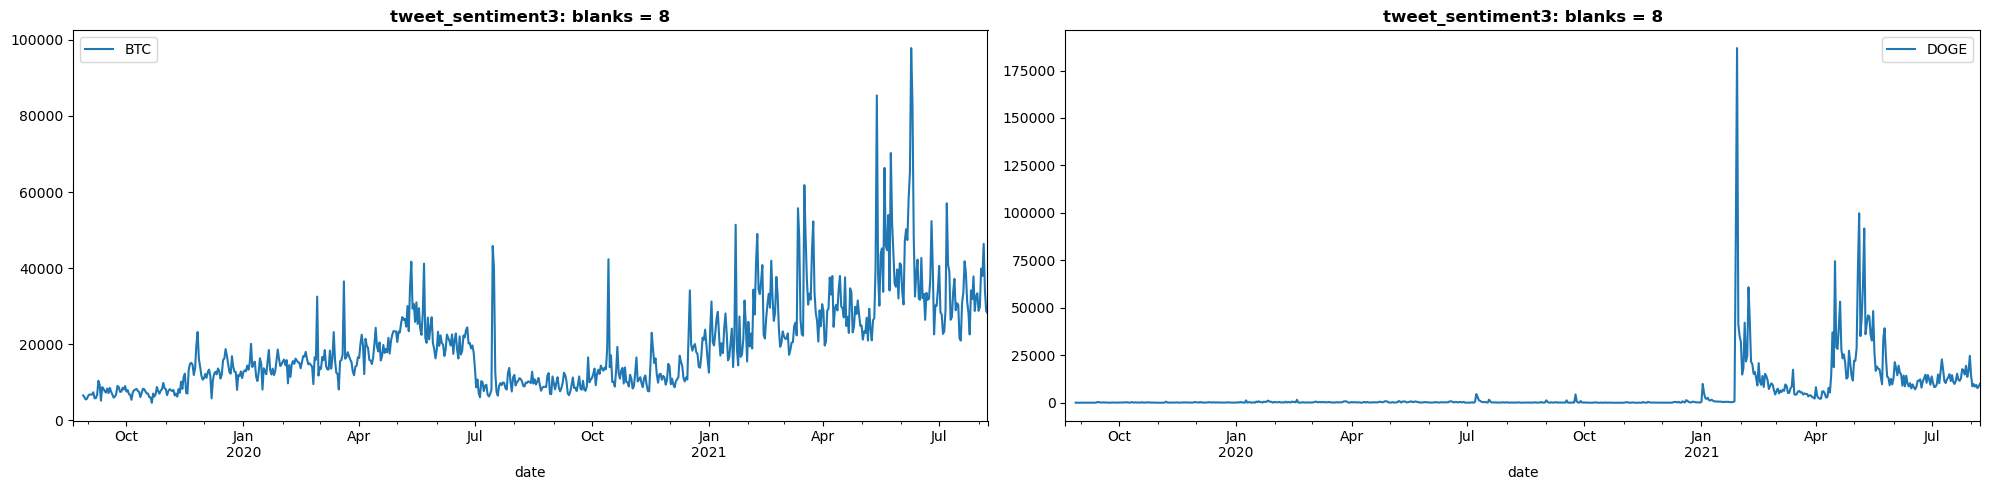

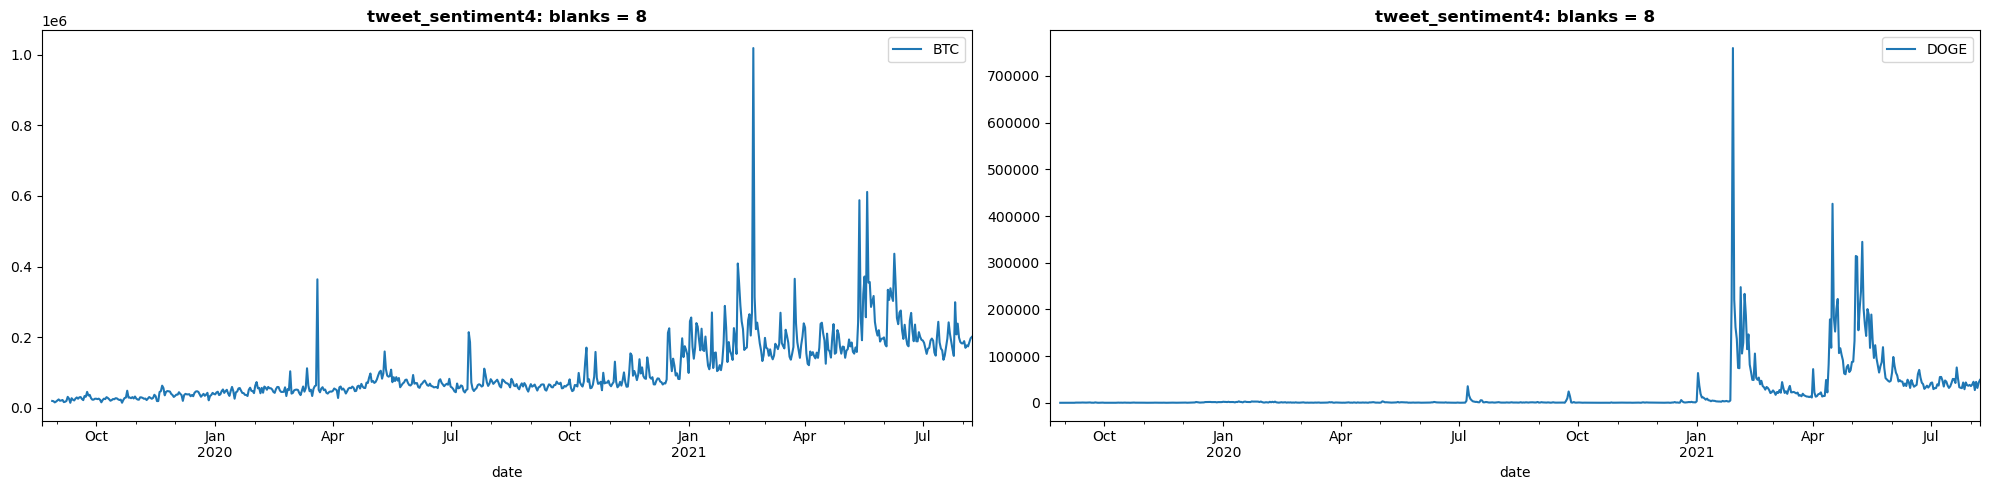

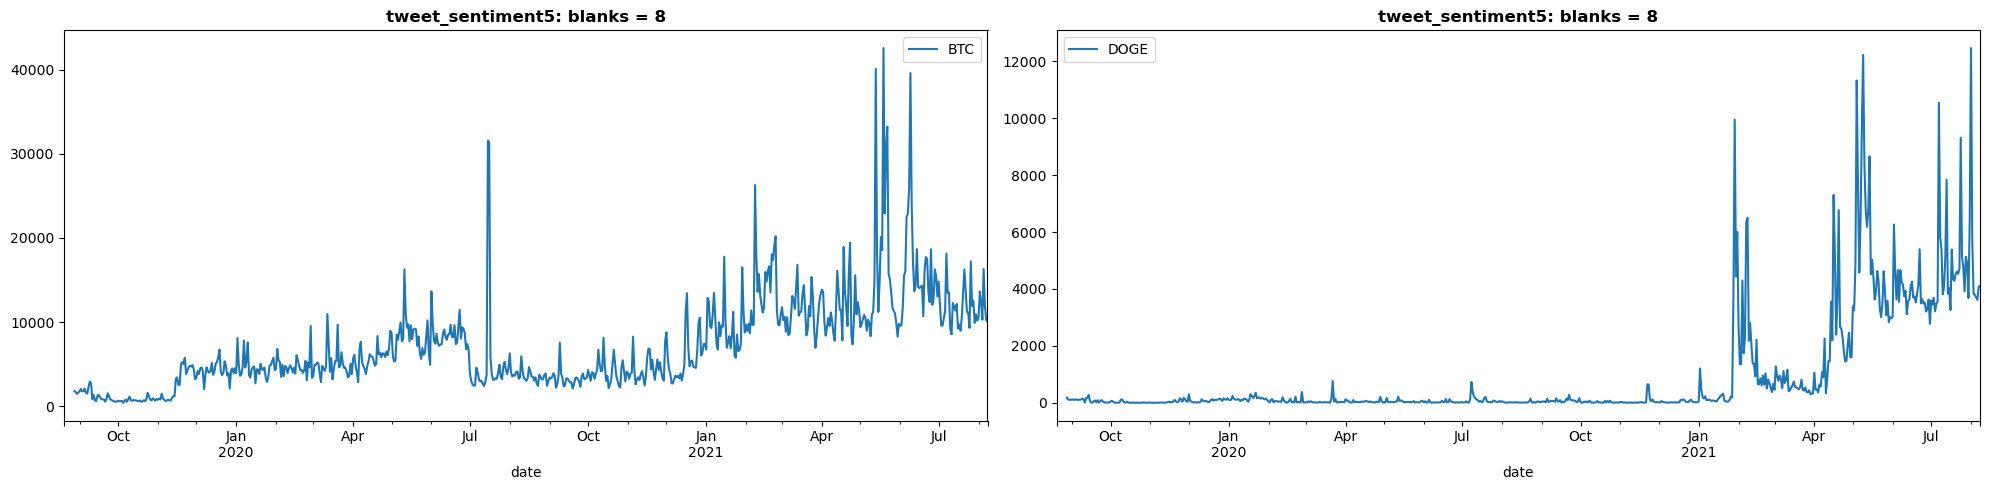

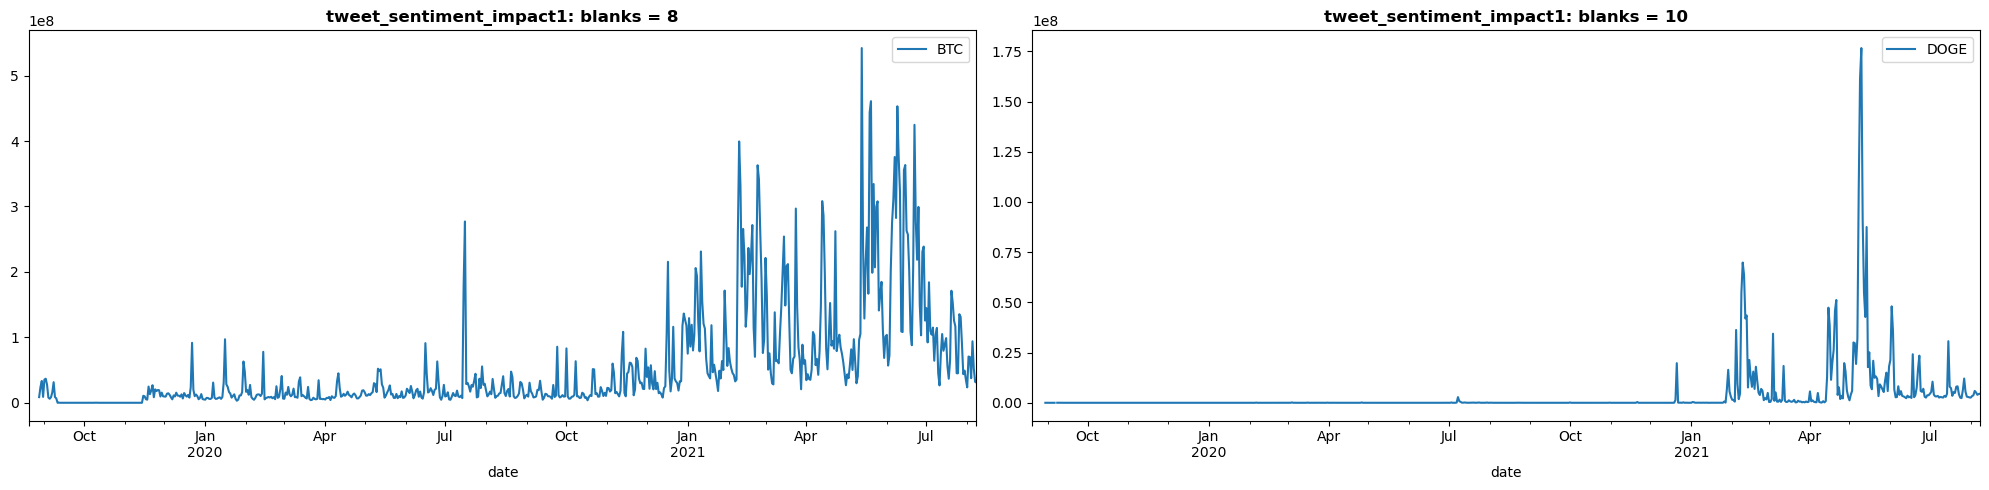

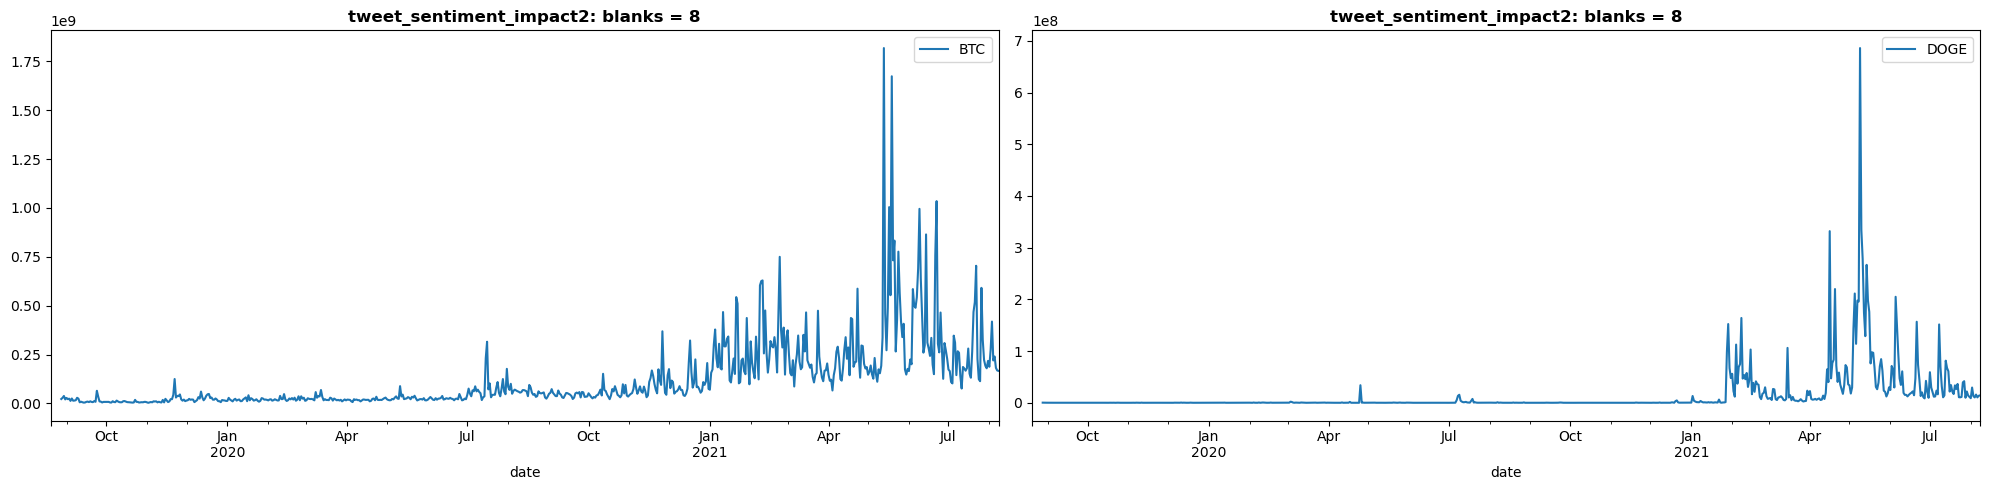

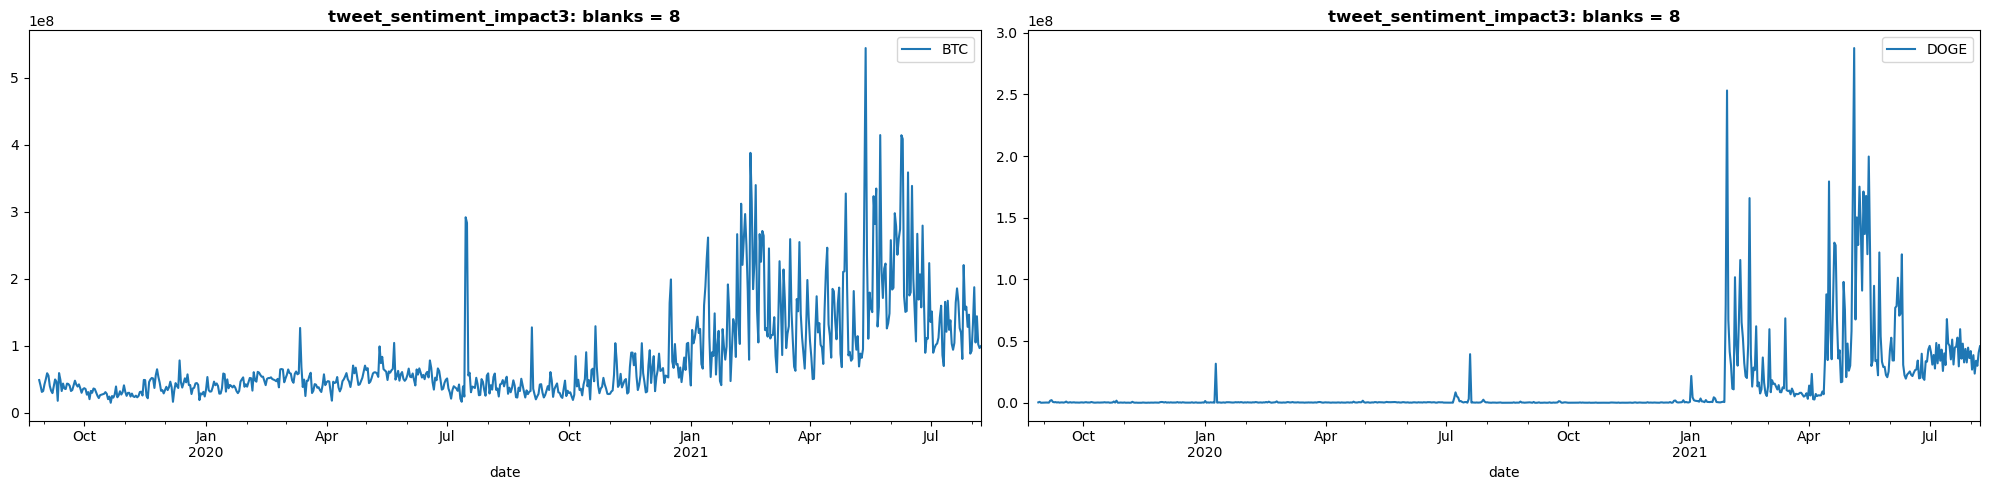

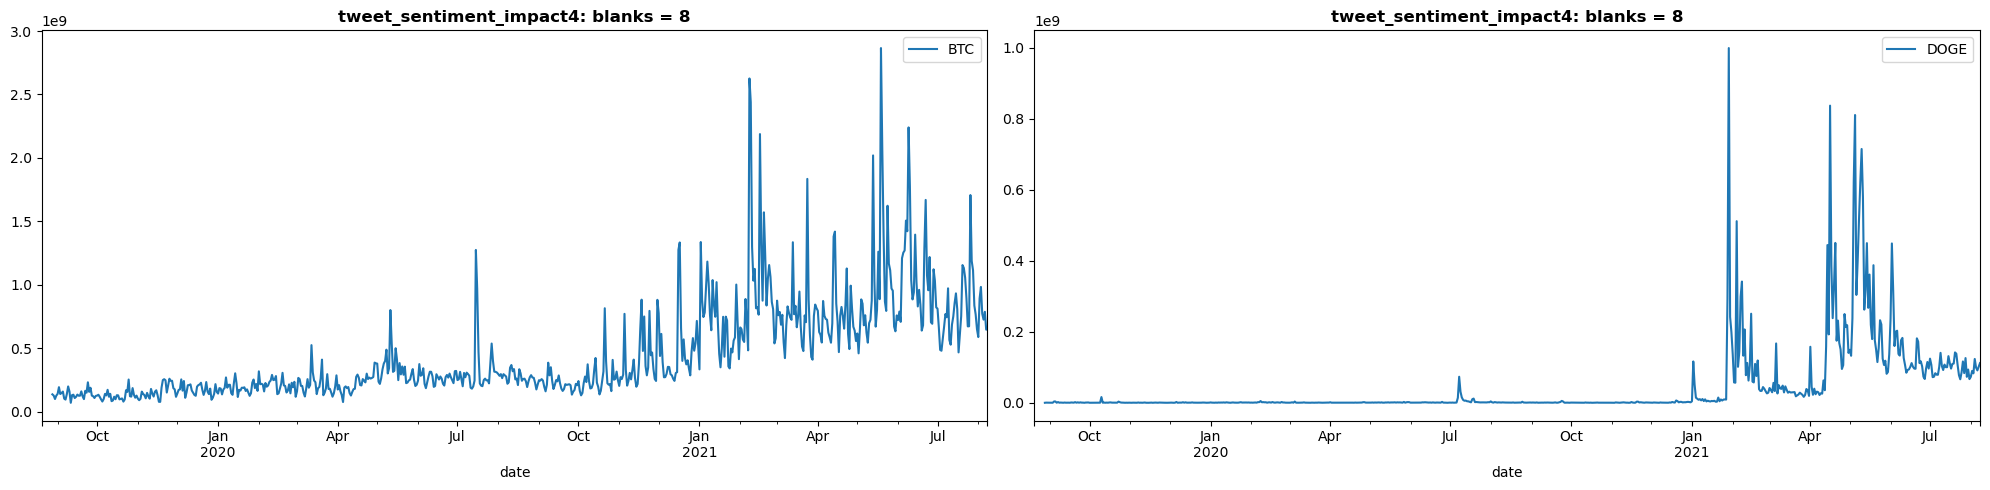

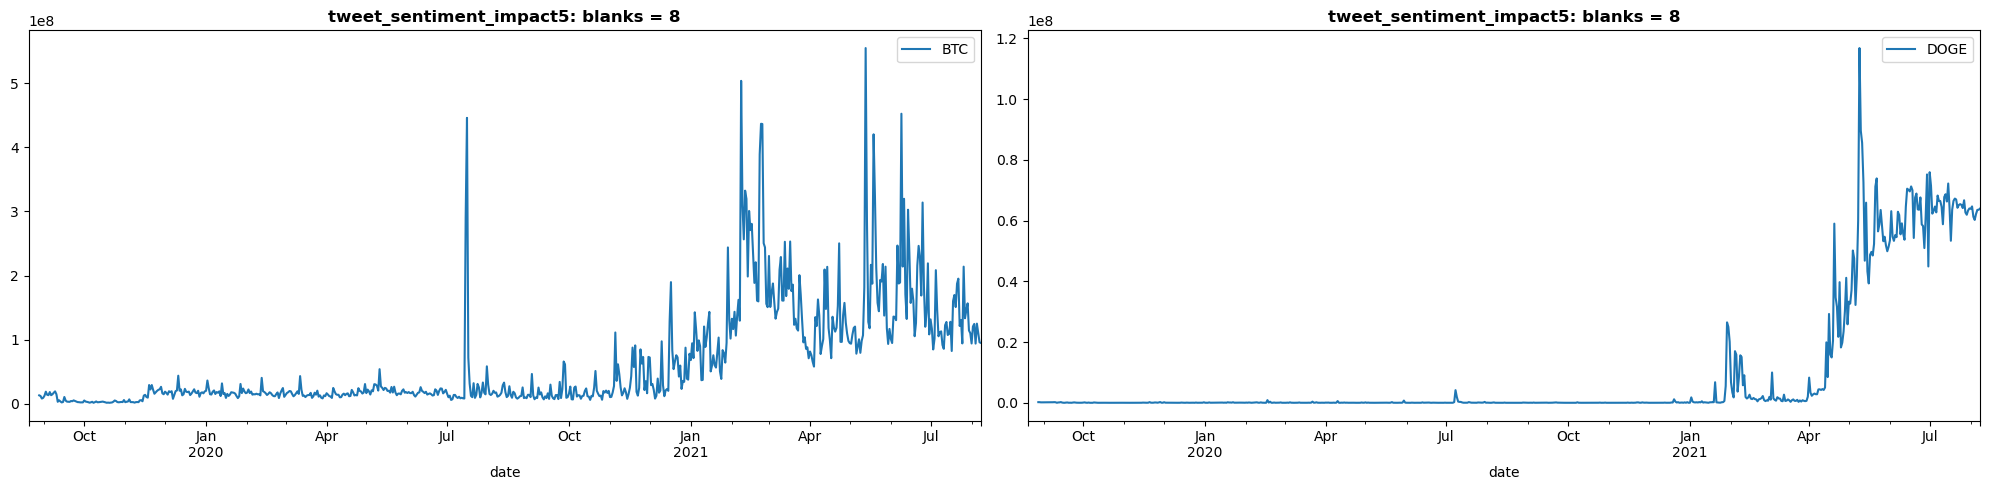

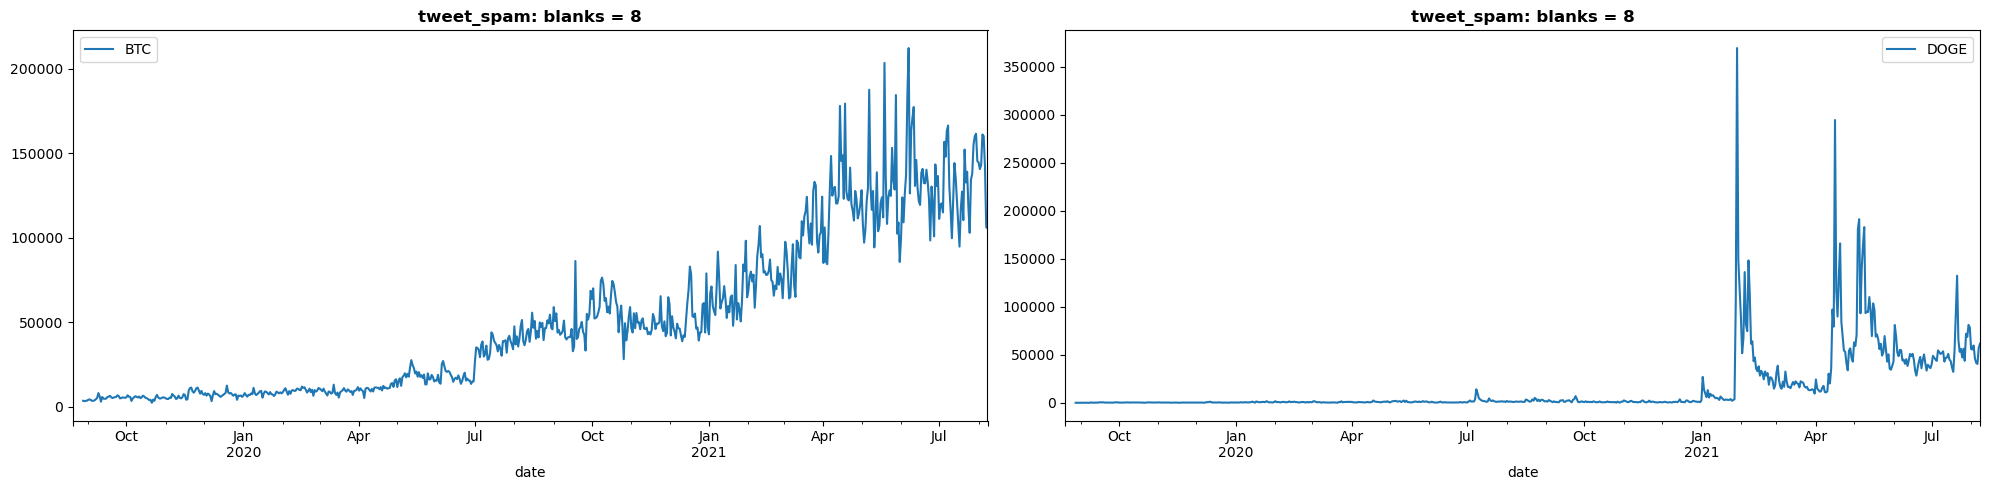

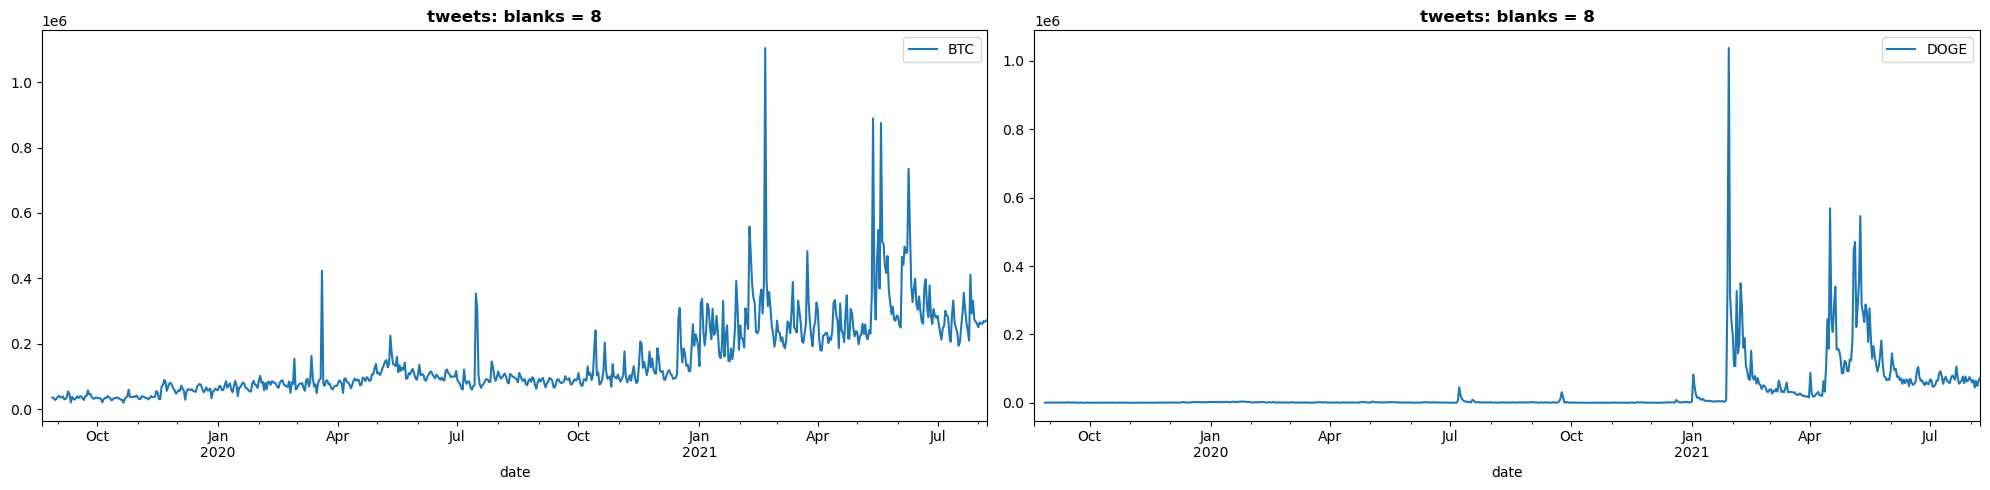

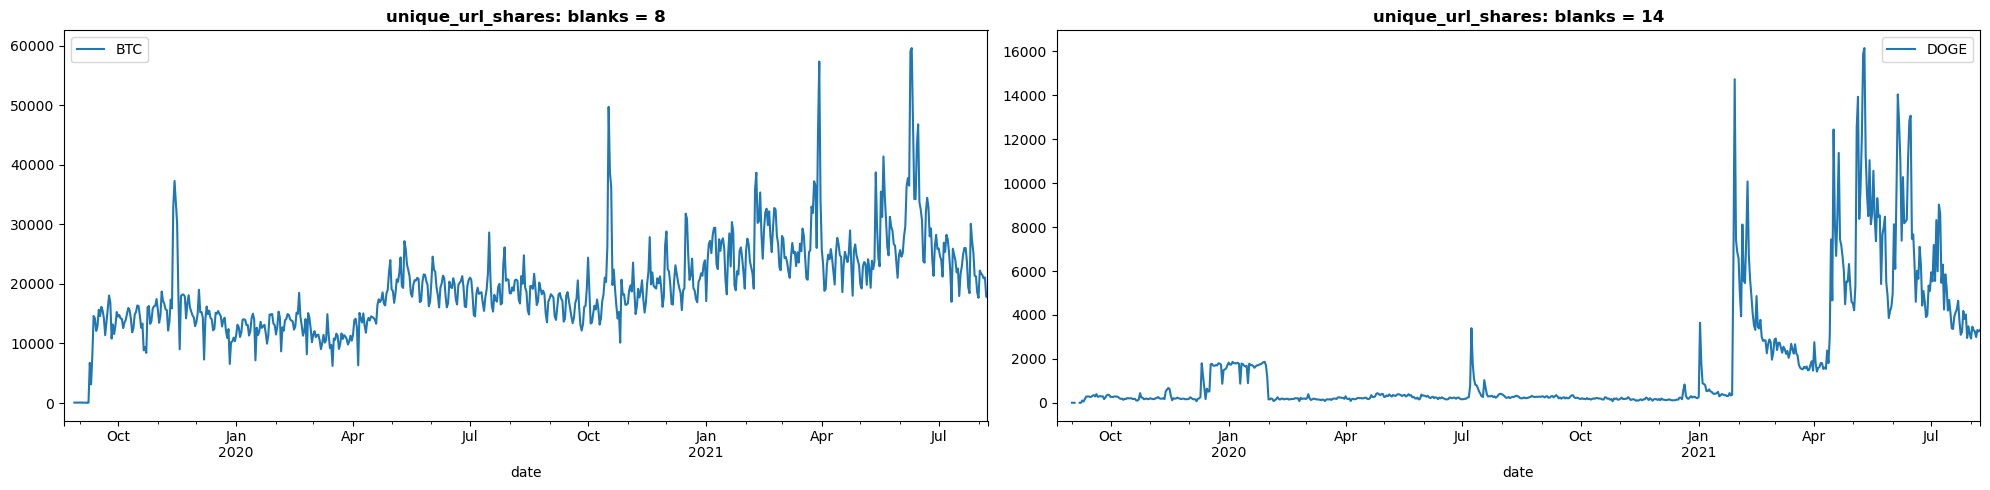

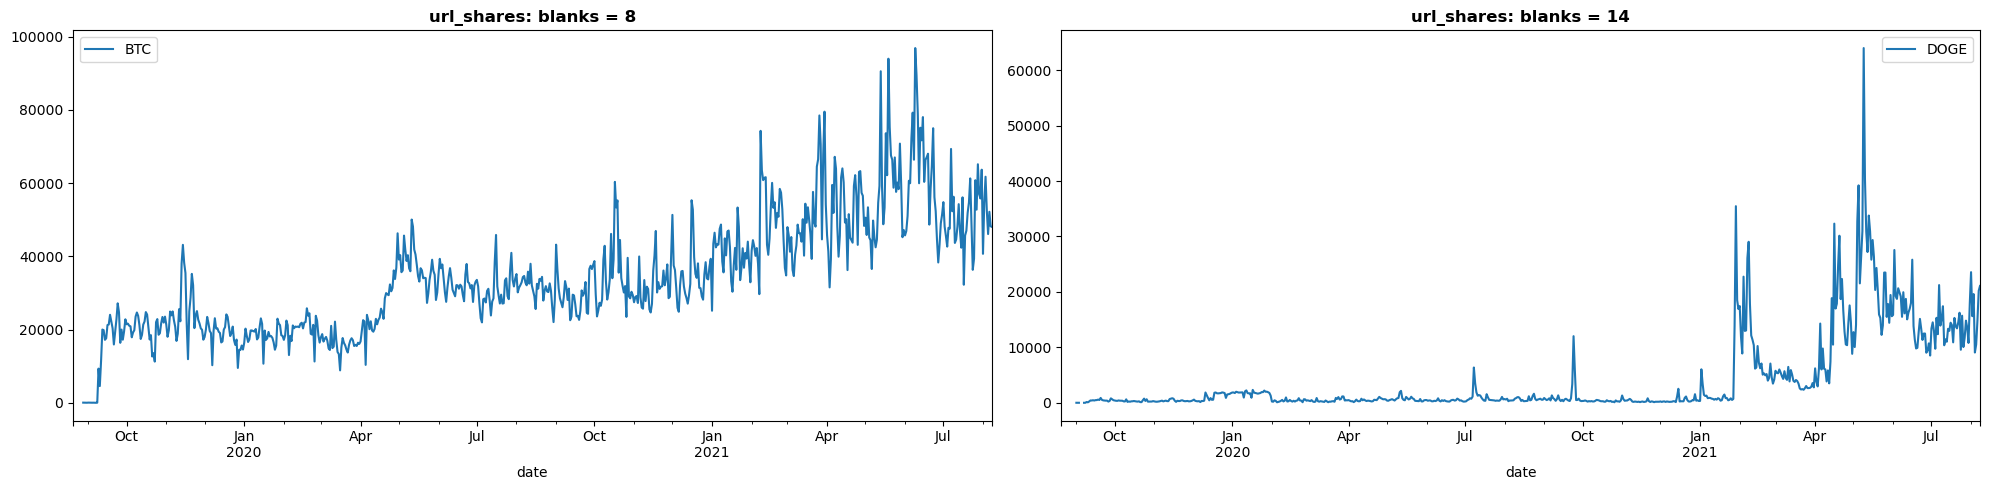

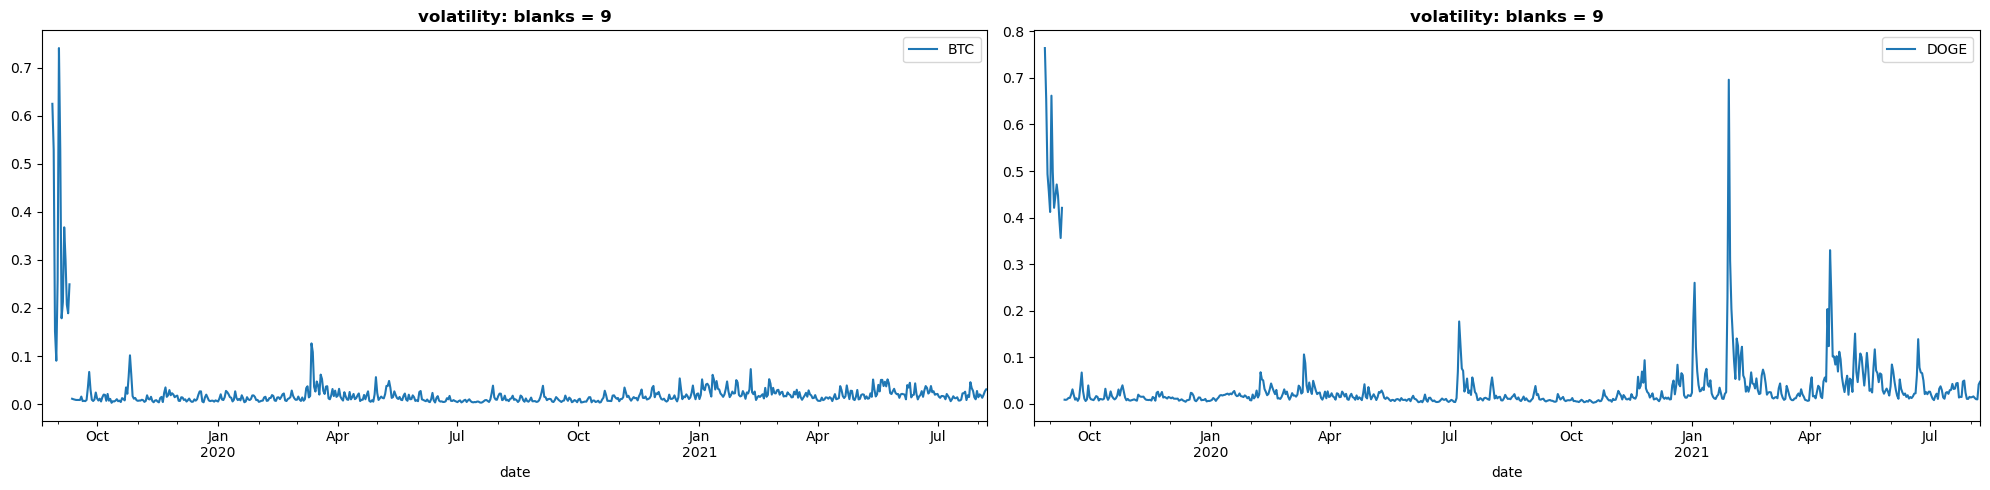

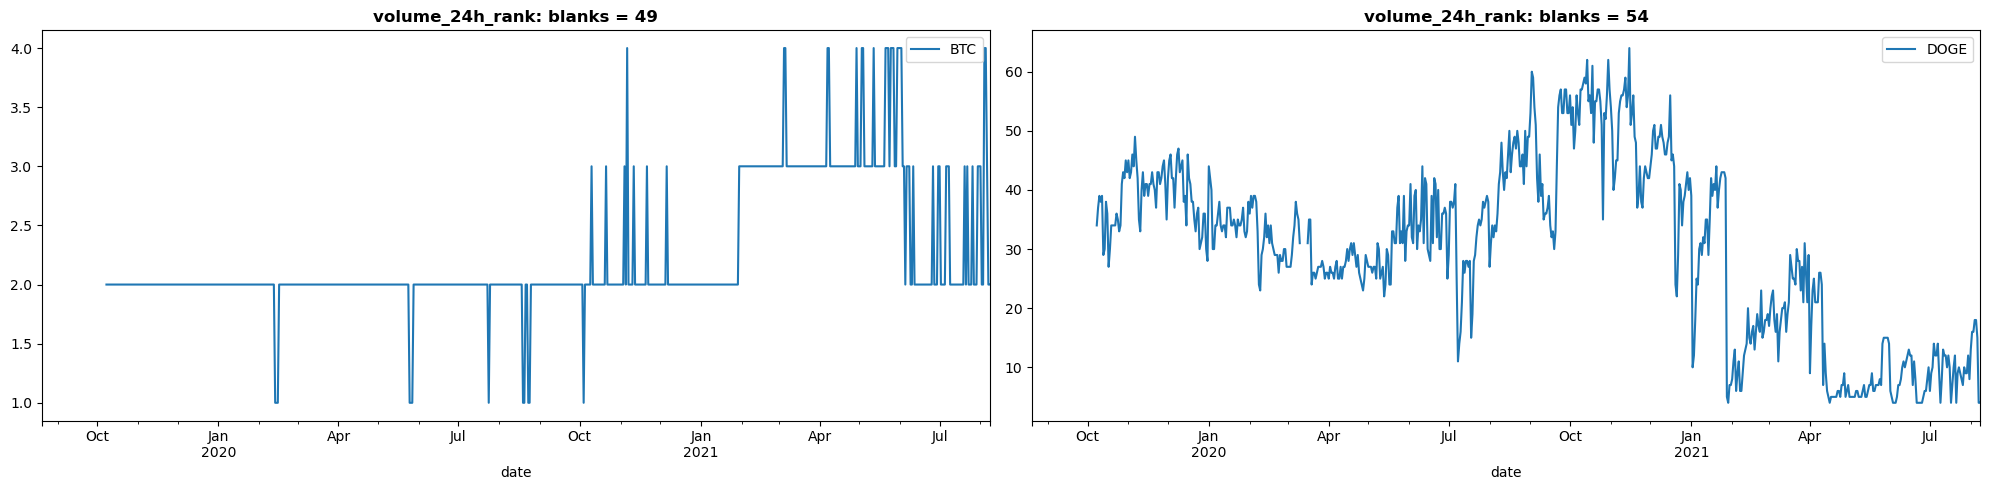

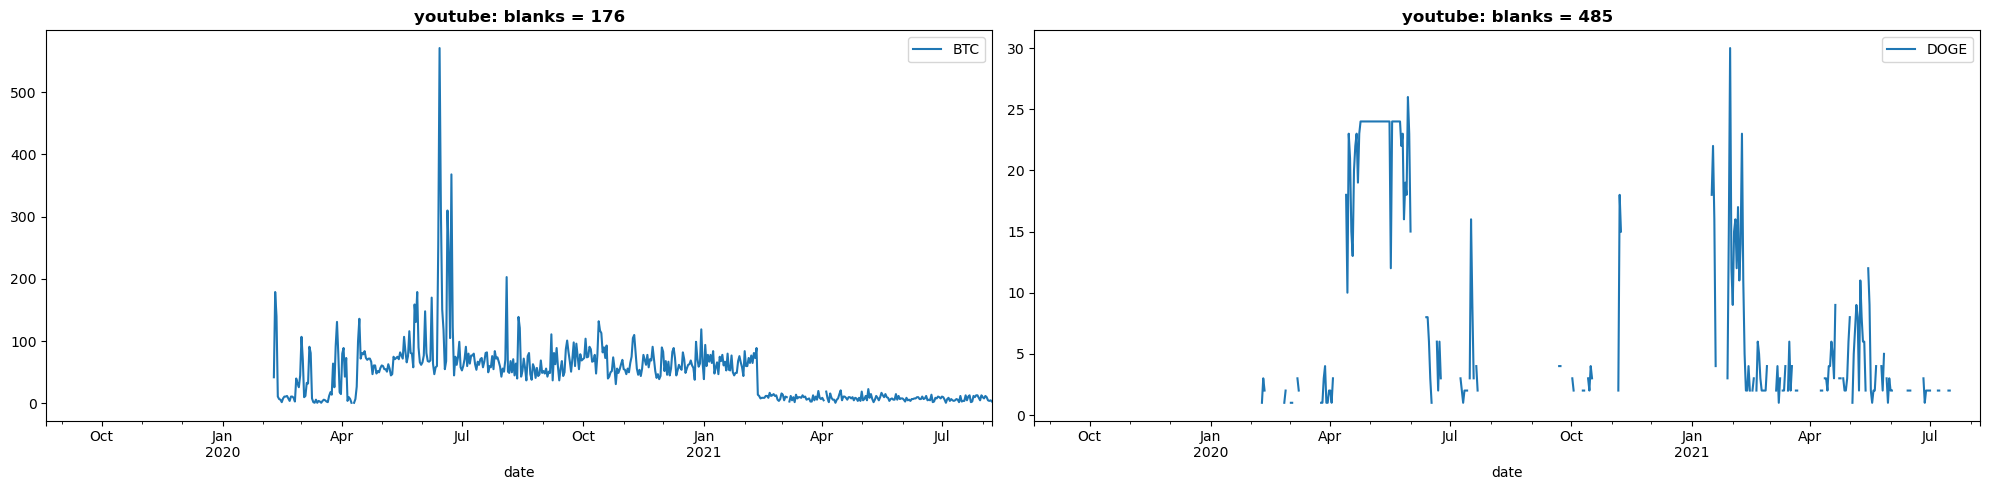

In [10]:
for col in sorted(blanks_set):
    fig, axes = plt.subplots(1,len(coins), figsize=(20,5))
    for i, coin in enumerate(coins):
        blanks = str(dfs[coin][col].isna().sum())
        ax = axes[i]
        dfs[coin][col].plot(ax=ax, label=coin)
        ax.set_title(col + ": blanks = " + blanks, fontweight='bold', size=12)
        ax.legend()
    plt.tight_layout()
    plt.show()

Most of the metrics with mising data are missing at the beginning of the time series or have a gap of 27-41 days in the Aug 2019 - Oct 2019 timeframe.

`medium` metric appears to be newer that started in Feb 2020 and also has intermittent blanks for DOGE.  This could be that DOGE was not as popular until recent.  Replace with zero but in the modeling staging may need to just exclude these 2 metrics.

`news` for DOGE has intermittent missing values so will replace with zero.

`search_average` metric appears to have been removed and is not populated after May 2020 so this column will be dropped.

`sentiment_absolute` metric is 3 for all coins so this column will be dropped.

`social_dominance` metric appears to no longer being populated with zeroes from Aug 2019.

`youtube` metric also appears to be newer that started in Feb 2020 so this may have been added with `medium`.

## 1.3 Data Cleaning

I want to have as much data as possible for the one-dimensional modeling based on `close` price.  Therefore, I'm only going to take action on some variables in the data wrangling step and will allow some blanks to flow through to the next phases of the project.

##### Bitcoin

In [11]:
btc = dfs['BTC'].copy()

today = date.today().strftime('%Y-%m-%d')

# Select all rows except for the current day
btc = btc[btc.index < today]

drop_cols = ['alt_rank_hour_average', 'search_average', 'sentiment_absolute', 'social_dominance']

btc = btc.drop(drop_cols, axis=1, errors='ignore')

zero_cols = ['medium', 'news', 'youtube']

btc[zero_cols] = btc[zero_cols].fillna(0)

btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2019-08-20 to 2021-08-06
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 718 non-null    int64  
 1   time                     718 non-null    int64  
 2   open                     718 non-null    float64
 3   close                    718 non-null    float64
 4   high                     718 non-null    float64
 5   low                      718 non-null    float64
 6   volume                   718 non-null    float64
 7   market_cap               696 non-null    float64
 8   url_shares               710 non-null    float64
 9   unique_url_shares        710 non-null    float64
 10  reddit_posts             710 non-null    float64
 11  reddit_posts_score       710 non-null    float64
 12  reddit_comments          710 non-null    float64
 13  reddit_comments_score    710 non-null    float64
 14  tweets 

For the missing values I want to make sure that they are at the start of the time series.  This way if I choose to include the feature in the model I know I will not lose data in the middle of the time series.

In [12]:
# Create function to get the min/max dates for columns with blanks
def check_min_max_date(df):
    blanks = df.columns[df.isna().any()].tolist()
    min_dt = []
    max_dt = []
    for col in blanks:
        min_dt.append(df[df[col].isna()].index.min())
        max_dt.append(df[df[col].isna()].index.max())
    blanks_df = pd.DataFrame(list(zip(min_dt, max_dt)), index=blanks, columns=['min_dt', 'max_dt'])
    print(blanks_df)
check_min_max_date(btc)

                            min_dt     max_dt
market_cap              2019-08-20 2019-09-11
url_shares              2019-08-20 2019-08-27
unique_url_shares       2019-08-20 2019-08-27
reddit_posts            2021-07-30 2021-08-06
reddit_posts_score      2021-07-30 2021-08-06
reddit_comments         2021-07-30 2021-08-06
reddit_comments_score   2021-07-30 2021-08-06
tweets                  2019-08-20 2019-08-27
tweet_spam              2019-08-20 2019-08-27
tweet_followers         2019-08-20 2019-09-08
tweet_quotes            2019-08-20 2019-09-08
tweet_retweets          2019-08-20 2019-09-08
tweet_replies           2019-08-20 2019-09-08
tweet_favorites         2019-08-20 2019-09-08
tweet_sentiment1        2019-08-20 2019-08-27
tweet_sentiment2        2019-08-20 2019-08-27
tweet_sentiment3        2019-08-20 2019-08-27
tweet_sentiment4        2019-08-20 2019-08-27
tweet_sentiment5        2019-08-20 2019-08-27
tweet_sentiment_impact1 2019-08-20 2019-08-27
tweet_sentiment_impact2 2019-08-20

It appears the `reddit_` comments have stopped populating since 7/30/201 so these will be dropped.

`social_volume_global` is missing 1 value in 2020 so will interpolate the gap in the time series for this one variable and leave the rest.

In [13]:
# Drop reddit columns
reddit_drop_cols = ['reddit_posts', 'reddit_posts_score', 'reddit_comments', 'reddit_comments_score']

btc = btc.drop(reddit_drop_cols, axis=1, errors='ignore')

# Interpolate the 1 missing blank for social_volume_global
btc['social_volume_global'] = btc['social_volume_global'].interpolate().round()

In [14]:
# Check min/max date blanks again
check_min_max_date(btc)

                            min_dt     max_dt
market_cap              2019-08-20 2019-09-11
url_shares              2019-08-20 2019-08-27
unique_url_shares       2019-08-20 2019-08-27
tweets                  2019-08-20 2019-08-27
tweet_spam              2019-08-20 2019-08-27
tweet_followers         2019-08-20 2019-09-08
tweet_quotes            2019-08-20 2019-09-08
tweet_retweets          2019-08-20 2019-09-08
tweet_replies           2019-08-20 2019-09-08
tweet_favorites         2019-08-20 2019-09-08
tweet_sentiment1        2019-08-20 2019-08-27
tweet_sentiment2        2019-08-20 2019-08-27
tweet_sentiment3        2019-08-20 2019-08-27
tweet_sentiment4        2019-08-20 2019-08-27
tweet_sentiment5        2019-08-20 2019-08-27
tweet_sentiment_impact1 2019-08-20 2019-08-27
tweet_sentiment_impact2 2019-08-20 2019-08-27
tweet_sentiment_impact3 2019-08-20 2019-08-27
tweet_sentiment_impact4 2019-08-20 2019-08-27
tweet_sentiment_impact5 2019-08-20 2019-08-27
social_score            2019-08-20

All remaining blanks are for periods of time in 2019 so if any of these columns are used in the modeling stage I will drop these blank rows and start the time series from that point.

##### Dogecoin

In [15]:
doge = dfs['DOGE'].copy()

# Select all rows except for the current day
doge = doge[doge.index < today]

doge = doge.drop(drop_cols, axis=1, errors='ignore')

doge[zero_cols] = doge[zero_cols].fillna(0)

doge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2019-08-20 to 2021-08-06
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   asset_id                 718 non-null    int64  
 1   time                     718 non-null    int64  
 2   open                     718 non-null    float64
 3   close                    718 non-null    float64
 4   high                     718 non-null    float64
 5   low                      718 non-null    float64
 6   volume                   718 non-null    float64
 7   market_cap               696 non-null    float64
 8   url_shares               704 non-null    float64
 9   unique_url_shares        704 non-null    float64
 10  reddit_posts             710 non-null    float64
 11  reddit_posts_score       710 non-null    float64
 12  reddit_comments          710 non-null    float64
 13  reddit_comments_score    710 non-null    float64
 14  tweets 

In [16]:
# Check min/max date blanks for doge
check_min_max_date(doge)

                            min_dt     max_dt
market_cap              2019-08-20 2019-09-11
url_shares              2019-08-20 2019-09-06
unique_url_shares       2019-08-20 2019-09-06
reddit_posts            2021-07-30 2021-08-06
reddit_posts_score      2021-07-30 2021-08-06
reddit_comments         2021-07-30 2021-08-06
reddit_comments_score   2021-07-30 2021-08-06
tweets                  2019-08-20 2019-08-27
tweet_spam              2019-08-20 2019-08-27
tweet_followers         2019-08-20 2019-09-08
tweet_quotes            2019-08-20 2019-09-08
tweet_retweets          2019-08-20 2019-09-08
tweet_replies           2019-08-20 2019-09-08
tweet_favorites         2019-08-20 2019-09-08
tweet_sentiment1        2019-08-20 2019-09-07
tweet_sentiment2        2019-08-20 2019-08-27
tweet_sentiment3        2019-08-20 2019-08-27
tweet_sentiment4        2019-08-20 2019-08-27
tweet_sentiment5        2019-08-20 2019-08-27
tweet_sentiment_impact1 2019-08-20 2019-09-07
tweet_sentiment_impact2 2019-08-20

In [17]:
# Drop reddit columns for doge
doge = doge.drop(reddit_drop_cols, axis=1, errors='ignore')

The rank columns have 5 missing values so let's explore that more closely.

In [18]:
rank_cols = ['alt_rank','alt_rank_30d','market_cap_rank','percent_change_24h_rank',
             'volume_24h_rank','social_volume_24h_rank', 'social_score_24h_rank']

doge[doge[rank_cols].isna().any(axis=1)]

asset_id        time      open     close      high       low  \
date                                                                       
2019-08-20        29  1566259200  0.002729  0.002722  0.002758  0.002702   
2019-08-21        29  1566345600  0.002578  0.002644  0.002678  0.002557   
2019-08-22        29  1566432000  0.002644  0.002659  0.002728  0.002601   
2019-08-23        29  1566518400  0.002717  0.002658  0.002740  0.002634   
2019-08-24        29  1566604800  0.002598  0.002626  0.002663  0.002587   
2019-08-25        29  1566691200  0.002598  0.002614  0.002665  0.002582   
2019-08-26        29  1566777600  0.002675  0.002636  0.002689  0.002621   
2019-08-27        29  1566864000  0.002588  0.002606  0.002646  0.002559   
2019-08-28        29  1566950400  0.002473  0.002504  0.002542  0.002431   
2019-08-29        29  1567036800  0.002439  0.002436  0.002479  0.002375   
2019-08-30        29  1567123200  0.002451  0.002458  0.002489  0.002420   
2019-08-31        29  1567209600  0.002468  0.002456  0.002509  0.002435   
2019-09-01        29  1567296000  0.002500  0.002475  0.002537  0.002454   
2019-09-02        29  1567382400  0.002612  0.002587  0.002657  0.002559   
2019-09-03        29  1567468800  0.002647  0.002589  0.002660  0.002532   
2019-09-04        29  1567555200  0.002577  0.002500  0.002601  0.002464   
2019-09-05        29  1567641600  0.002527  0.002501  0.002551  0.002455   
2019-09-06        29  1567728000  0.002410  0.002459  0.002504  0.002293   
2019-09-07        29  1567814400  0.002495  0.002476  0.002537  0.002372   
2019-09-08        29  1567900800  0.002450  0.002459  0.002518  0.002400   
2019-09-09        29  1567987200  0.002440  0.002438  0.002478  0.002375   
2019-09-10        29  1568073600  0.002374  0.002410  0.002439  0.002349   
2019-09-11        29  1568160000  0.002420  0.002398  0.002452  0.002363   
2019-09-12        29  1568246400  0.002465  0.002420  0.002486  0.002384   
2019-09-13        29  1568332800  0.002405  0.002427  0.002465  0.002372   
2019-09-14        29  1568419200  0.002451  0.002438  0.002490  0.002383   
2019-09-15        29  1568505600  0.002425  0.002445  0.002529  0.002381   
2019-09-16        29  1568592000  0.002456  0.002448  0.002526  0.002395   
2019-09-17        29  1568678400  0.002420  0.002562  0.002623  0.002374   
2019-09-18        29  1568764800  0.002598  0.002707  0.002818  0.002534   
2019-09-19        29  1568851200  0.003370  0.002695  0.003482  0.002642   
2019-09-20        29  1568937600  0.002660  0.002656  0.002730  0.002622   
2019-09-21        29  1569024000  0.002617  0.002560  0.002638  0.002517   
2019-09-22        29  1569110400  0.002574  0.002577  0.002623  0.002521   
2019-09-23        29  1569196800  0.002468  0.002456  0.002515  0.002429   
2019-09-24        29  1569283200  0.002154  0.002181  0.002237  0.002054   
2019-09-25        29  1569369600  0.002173  0.002185  0.002209  0.002118   
2019-09-26        29  1569456000  0.002086  0.002126  0.002152  0.002063   
2019-09-27        29  1569542400  0.002172  0.002190  0.002224  0.002149   
2019-09-28        29  1569628800  0.002204  0.002219  0.002250  0.002164   
2019-09-29        29  1569715200  0.002156  0.002201  0.002231  0.002135   
2019-09-30        29  1569801600  0.002292  0.002386  0.002468  0.002250   
2019-10-01        29  1569888000  0.002388  0.002365  0.002448  0.002335   
2019-10-02        29  1569974400  0.002378  0.002326  0.002413  0.002304   
2019-10-03        29  1570060800  0.002292  0.002293  0.002317  0.002261   
2019-10-04        29  1570147200  0.002273  0.002299  0.002321  0.002247   
2019-10-05        29  1570233600  0.002292  0.002303  0.002326  0.002282   
2019-10-06        29  1570320000  0.002218  0.002262  0.002279  0.002207   
2019-10-07        29  1570406400  0.002366  0.002339  0.002384  0.002314   
2020-03-11        29  1583884800  0.002148  0.002221  0.002298  0.002143   
2020-03-12        29  1583971200  0.001367  0.001530  0.0015

Despite all of the blanks <= 10/7/19 the timeframe is sort of random from 3/11/20 - 3/15/20.

In [19]:
doge[rank_cols][doge.index >= '2020-03-01'].head(20)

alt_rank  alt_rank_30d  market_cap_rank  percent_change_24h_rank  \
date                                                                           
2020-03-01      10.0          26.0             32.0                    323.0   
2020-03-02      82.0          27.0             32.0                    760.0   
2020-03-03       4.0          23.0             32.0                    186.0   
2020-03-04     189.0          22.0             32.0                   1386.0   
2020-03-05       4.0          22.0             32.0                    252.0   
2020-03-06     154.0          21.0             32.0                   1257.0   
2020-03-07      52.0          21.0             32.0                    955.0   
2020-03-08      12.0          22.0             33.0                    779.0   
2020-03-09      53.0          27.0             32.0                    831.0   
2020-03-10      24.0          24.0             30.0                    900.0   
2020-03-11       NaN           NaN              NaN                      NaN   
2020-03-12       NaN           NaN              NaN                      NaN   
2020-03-13       NaN           NaN              NaN                      NaN   
2020-03-14       NaN           NaN              NaN                      NaN   
2020-03-15       NaN           NaN              NaN                      NaN   
2020-03-16       2.0          23.0             29.0                    406.0   
2020-03-17     138.0          24.0             30.0                   1155.0   
2020-03-18      44.0          25.0             30.0                    770.0   
2020-03-19      89.0          25.0             31.0                    845.0   
2020-03-20      84.0          26.0             31.0                   1169.0   

            volume_24h_rank  social_volume_24h_rank  social_score_24h_rank  
date                                                                        
2020-03-01             27.0                    19.0                   35.0  
2020-03-02             27.0                    20.0                   61.0  
2020-03-03             27.0                     9.0                   14.0  
2020-03-04             29.0                    14.0                   15.0  
2020-03-05             32.0                    21.0                   14.0  
2020-03-06             34.0                    23.0                   49.0  
2020-03-07             38.0                    27.0                   38.0  
2020-03-08             36.0                    18.0                   28.0  
2020-03-09             35.0                    19.0                   33.0  
2020-03-10             31.0                    19.0                   22.0  
2020-03-11              NaN                     NaN                    NaN  
2020-03-12              NaN                     NaN                    NaN  
2020-03-13              NaN                     NaN                    NaN  
2020-03-14              NaN                     NaN                    NaN  
2020-03-15              NaN                     NaN                    NaN  
2020-03-16             31.0                    19.0                   24.0  
2020-03-17             35.0                    22.0                   37.0  
2020-03-18             35.0                    24.0                   61.0  
2020-03-19             24.0                    32.0                   40.0  
2020-03-20             26.0                    20.0                   36.0

For DOGE there could have been an issue with the rankings during this timeframe so will interpolate the gap in the time series.

In [20]:
# Interpolate the missing values only after 3/1/20
doge.loc['2020-03-01':'2020-03-31', rank_cols] = doge.loc['2020-03-01':'2020-03-31', rank_cols].interpolate().round()

doge[rank_cols][doge.index >= '2020-03-01'].head(20)

alt_rank  alt_rank_30d  market_cap_rank  percent_change_24h_rank  \
date                                                                           
2020-03-01      10.0          26.0             32.0                    323.0   
2020-03-02      82.0          27.0             32.0                    760.0   
2020-03-03       4.0          23.0             32.0                    186.0   
2020-03-04     189.0          22.0             32.0                   1386.0   
2020-03-05       4.0          22.0             32.0                    252.0   
2020-03-06     154.0          21.0             32.0                   1257.0   
2020-03-07      52.0          21.0             32.0                    955.0   
2020-03-08      12.0          22.0             33.0                    779.0   
2020-03-09      53.0          27.0             32.0                    831.0   
2020-03-10      24.0          24.0             30.0                    900.0   
2020-03-11      20.0          24.0             30.0                    818.0   
2020-03-12      17.0          24.0             30.0                    735.0   
2020-03-13      13.0          24.0             30.0                    653.0   
2020-03-14       9.0          23.0             29.0                    571.0   
2020-03-15       6.0          23.0             29.0                    488.0   
2020-03-16       2.0          23.0             29.0                    406.0   
2020-03-17     138.0          24.0             30.0                   1155.0   
2020-03-18      44.0          25.0             30.0                    770.0   
2020-03-19      89.0          25.0             31.0                    845.0   
2020-03-20      84.0          26.0             31.0                   1169.0   

            volume_24h_rank  social_volume_24h_rank  social_score_24h_rank  
date                                                                        
2020-03-01             27.0                    19.0                   35.0  
2020-03-02             27.0                    20.0                   61.0  
2020-03-03             27.0                     9.0                   14.0  
2020-03-04             29.0                    14.0                   15.0  
2020-03-05             32.0                    21.0                   14.0  
2020-03-06             34.0                    23.0                   49.0  
2020-03-07             38.0                    27.0                   38.0  
2020-03-08             36.0                    18.0                   28.0  
2020-03-09             35.0                    19.0                   33.0  
2020-03-10             31.0                    19.0                   22.0  
2020-03-11             31.0                    19.0                   22.0  
2020-03-12             31.0                    19.0                   23.0  
2020-03-13             31.0                    19.0                   23.0  
2020-03-14             31.0                    19.0                   23.0  
2020-03-15             31.0                    19.0                   24.0  
2020-03-16             31.0                    19.0                   24.0  
2020-03-17             35.0                    22.0                   37.0  
2020-03-18             35.0                    24.0                   61.0  
2020-03-19             24.0                    32.0                   40.0  
2020-03-20             26.0                    20.0                   36.0

In [21]:
# Check min/max date blanks for doge again
check_min_max_date(doge)

                            min_dt     max_dt
market_cap              2019-08-20 2019-09-11
url_shares              2019-08-20 2019-09-06
unique_url_shares       2019-08-20 2019-09-06
tweets                  2019-08-20 2019-08-27
tweet_spam              2019-08-20 2019-08-27
tweet_followers         2019-08-20 2019-09-08
tweet_quotes            2019-08-20 2019-09-08
tweet_retweets          2019-08-20 2019-09-08
tweet_replies           2019-08-20 2019-09-08
tweet_favorites         2019-08-20 2019-09-08
tweet_sentiment1        2019-08-20 2019-09-07
tweet_sentiment2        2019-08-20 2019-08-27
tweet_sentiment3        2019-08-20 2019-08-27
tweet_sentiment4        2019-08-20 2019-08-27
tweet_sentiment5        2019-08-20 2019-08-27
tweet_sentiment_impact1 2019-08-20 2019-09-07
tweet_sentiment_impact2 2019-08-20 2019-08-27
tweet_sentiment_impact3 2019-08-20 2019-08-27
tweet_sentiment_impact4 2019-08-20 2019-08-27
tweet_sentiment_impact5 2019-08-20 2019-08-27
social_score            2019-08-20

All remaining blanks are for periods of time in 2019 so if any of these columns are used in the modeling stage I will drop these blank rows and start the time series from that point.

## 1.4 Buy/Hold/Sell Decision

For this project I'm going to build 2 different models:

1. Time Series modeling for price predictions for the next 7 days.
2. Multi-class classification model for a Buy, Hold or Sell recommendation over a 7 day window from the most recent closing price.

The buy/hold/sell decision logic is based on a forward looking window.

Buy:
1. Maximum gain during the window is > the desired threshold
2. Change in close price from the start to end of window is higher (window candle is green)
3. Lowest price during the window is >= the low price for the current day

Sell:
1. Maximum loss during the window is < the desired threshold
2. Change in close price from the start to end of window is lower (window candle is red)
3. Highest price during the window is <= the high price for the current day

All else the decision is Hold.

In [22]:
# Apply forward looking window metrics to data
btc = window_metrics(btc, 7, 1, .05)
doge = window_metrics(doge, 7, 1, .05)

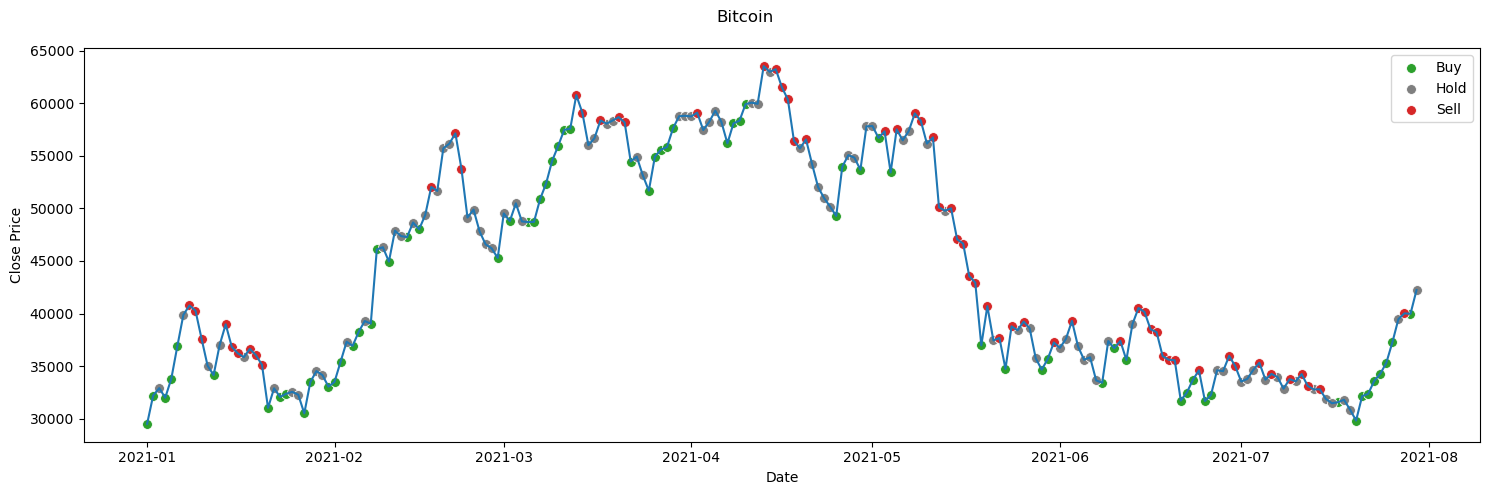

In [23]:
# Plot 2021 close prices for BTC
fig, ax = plt.subplots(figsize=(15,5))
btc_filtered = btc.loc['2021-01-01':].dropna()
decision_plot(btc_filtered, ax)
plt.show()

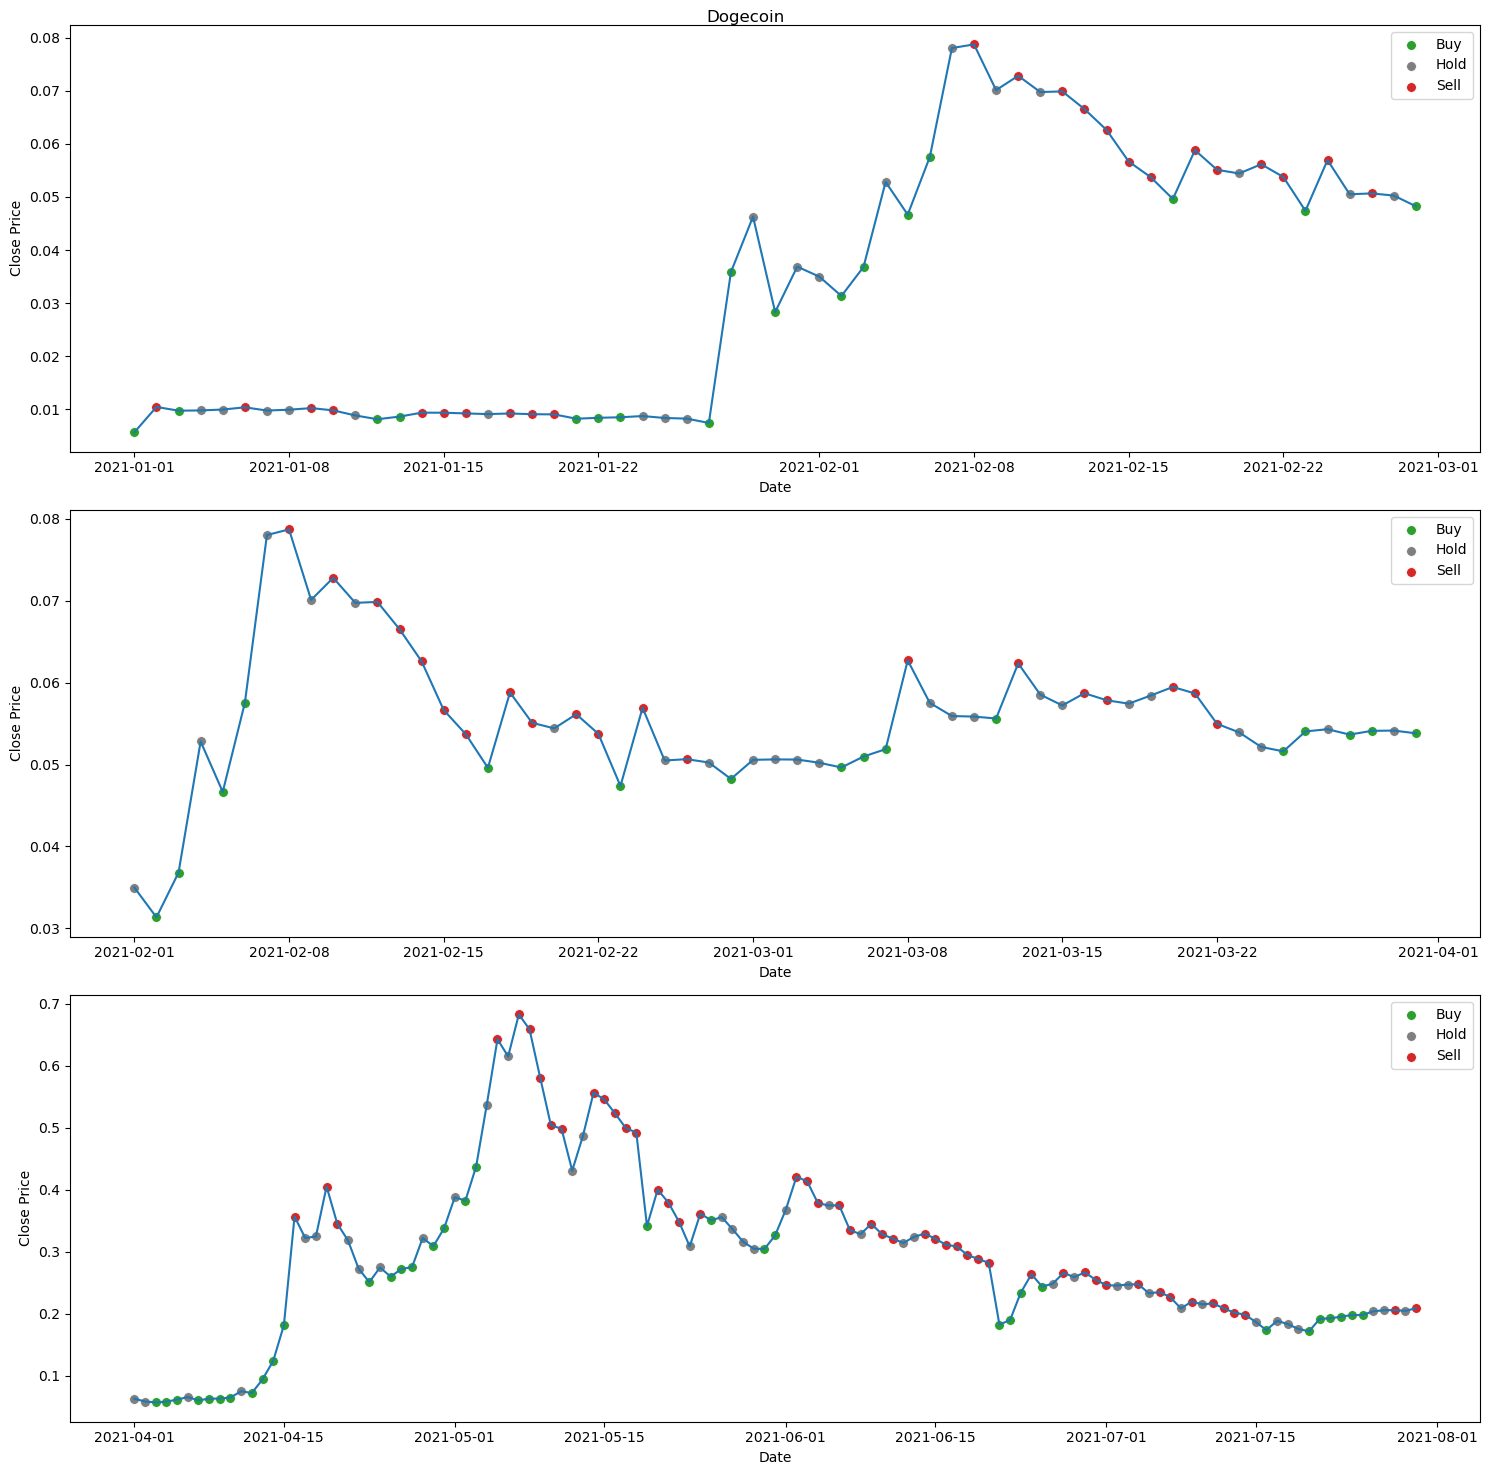

In [24]:
# Plot 2021 close prices for DOGE
fig, ax = plt.subplots(3,1, figsize=(15,15))
doge_filtered = doge.loc['2021-01-01':'2021-02-28']
decision_plot(doge_filtered, ax[0])
doge_filtered = doge.loc['2021-02-01':'2021-03-31']
decision_plot(doge_filtered, ax[1])
doge_filtered = doge.loc['2021-04-01':].dropna()
decision_plot(doge_filtered, ax[2])
plt.show()

The Buy/Hold/Sell decision logic for BTC is pretty effective at recommending to buy at the bottom of the trough or as the price is going up and then recommending to sell at the peak or just before the peak.  I split up the DOGE charts just to get a better visual due to large price swings since January 2021.

## 1.5 Save Data

I will save the data for the exploratory data analysis and modeling stages to avoid the time period changing.

In [25]:
interim_dir = r'..\data\interim'
btc.to_csv(os.path.join(interim_dir, 'btc.csv'))
doge.to_csv(os.path.join(interim_dir, 'doge.csv'))